# Overview

In this notebook, we conduct outlier detecion of the dataset obtained from the previous data cleaning. After that we perform the statistical analysis of the data in order to see how the data is distributed among the variables. 

**Author**: Jon Maestre Escobar

**Email**: jonmaestre@opendeusto.es.

In [36]:
import pandas as pd
import numpy as np
import warnings
import pandas as pd
from utilities import Data_cleaning

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
import re
%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [14]:
df = pd.read_hdf('../data/cleaned_dataset_v1.h5',  key='data')
df.fillna(0, inplace=True)
df.shape

(46192, 9142)

# Datacleaning and preprocessing


The data cleaning performed in the current session involves eliminating columns where all values are zero, as well as removing the initial number of series calculated from the merged file. Subsequently, recalculations were done using columns from the processed table in data_merged_table.ipynb. Additionally, total reps and total time values were calculated for all exercises, as well as for individual exercises.

## Nomenclature

- **variable**: Number of series. (e.g. 1 leg bridge (left) = 10)
- **variable**\_**reps**\_**n**: Number of reps per serie . (e.g. 1 leg bridge (left)_reps_1 = 5 -> 5 reps in the serie 1)
- **variable**\_**time**\_**n**: Time in seconds per serie (e.g. 1 leg bridge (left)_time_2 = 30s -> 30s in the serie 2)
- **sum_of_reps**: Sum of all the rep values executed during the session.
- **sum_of_time**: Sum of the total time values for all the exercises during the session.
- **sum_of_reps_per_exercise**: Sum of the rep values executed during the session per exercise.
- **sum_of_time_per_exercise**: Sum of the time values during the session per exercise.
- **total_count_of_series_reps**: The count of the series for reps.
- **total_count_of_series_time**: The count of the sereis for time.


In [15]:
# Removing all columns with zero values
columns_with_zero_values = df.columns[(df == 0).all()]
df = df.drop(columns=columns_with_zero_values)
df.head(5)

,session_executions_updated_at,user_programs_user_id,1 leg bridge (left),1 leg bridge (left)_reps_1,1 leg bridge (left)_reps_10,1 leg bridge (left)_reps_11,1 leg bridge (left)_reps_12,1 leg bridge (left)_reps_13,1 leg bridge (left)_reps_14,1 leg bridge (left)_reps_15,1 leg bridge (left)_reps_16,1 leg bridge (left)_reps_17,1 leg bridge (left)_reps_2,1 leg bridge (left)_reps_3,1 leg bridge (left)_reps_4,1 leg bridge (left)_reps_5,1 leg bridge (left)_reps_6,1 leg bridge (left)_reps_7,1 leg bridge (left)_reps_8,1 leg bridge (left)_reps_9,1 leg bridge (left)_time_1,1 leg bridge (left)_time_10,1 leg bridge (left)_time_11,1 leg bridge (left)_time_12,1 leg bridge (left)_time_13,1 leg bridge (left)_time_14,1 leg bridge (left)_time_15,1 leg bridge (left)_time_16,1 leg bridge (left)_time_17,1 leg bridge (left)_time_2,1 leg bridge (left)_time_3,1 leg bridge (left)_time_4,1 leg bridge (left)_time_5,1 leg bridge (left)_time_6,1 leg bridge (left)_time_7,1 leg bridge (left)_time_8,1 leg bridge (left)_time_9,1 leg bridge (right),1 leg bridge (right)_reps_1,1 leg bridge (right)_reps_10,1 leg bridge (right)_reps_11,1 leg bridge (right)_reps_12,1 leg bridge (right)_reps_13,1 leg bridge (right)_reps_14,1 leg bridge (right)_reps_15,1 leg bridge (right)_reps_16,1 leg bridge (right)_reps_17,1 leg bridge (right)_reps_2,1 leg bridge (right)_reps_3,1 leg bridge (right)_reps_4,1 leg bridge (right)_reps_5,1 leg bridge (right)_reps_6,1 leg bridge (right)_reps_7,1 leg bridge (right)_reps_8,1 leg bridge (right)_reps_9,1 leg bridge (right)_time_1,1 leg bridge (right)_time_10,1 leg bridge (right)_time_11,1 leg bridge (right)_time_12,1 leg bridge (right)_time_13,1 leg bridge (right)_time_14,1 leg bridge (right)_time_15,1 leg bridge (right)_time_16,1 leg bridge (right)_time_17,1 leg bridge (right)_time_2,1 leg bridge (right)_time_3,1 leg bridge (right)_time_4,1 leg bridge (right)_time_5,1 leg bridge (right)_time_6,1 leg bridge (right)_time_7,1 leg bridge (right)_time_8,1 leg bridge (right)_time_9,1 leg dead lift (left),1 leg dead lift (left)_reps_1,1 leg dead lift (left)_reps_10,1 leg dead lift (left)_reps_11,1 leg dead lift (left)_reps_12,1 leg dead lift (left)_reps_13,1 leg dead lift (left)_reps_14,1 leg dead lift (left)_reps_15,1 leg dead lift (left)_reps_2,1 leg dead lift (left)_reps_3,1 leg dead lift (left)_reps_4,1 leg dead lift (left)_reps_5,1 leg dead lift (left)_reps_6,1 leg dead lift (left)_reps_7,1 leg dead lift (left)_reps_8,1 leg dead lift (left)_reps_9,1 leg dead lift (left)_time_1,1 leg dead lift (left)_time_10,1 leg dead lift (left)_time_11,1 leg dead lift (left)_time_12,1 leg dead lift (left)_time_13,1 leg dead lift (left)_time_14,1 leg dead lift (left)_time_15,1 leg dead lift (left)_time_2,1 leg dead lift (left)_time_3,1 leg dead lift (left)_time_4,1 leg dead lift (left)_time_5,1 leg dead lift (left)_time_6,1 leg dead lift (left)_time_7,1 leg dead lift (left)_time_8,1 leg dead lift (left)_time_9,1 leg dead lift (right),1 leg dead lift (right)_reps_1,1 leg dead lift (right)_reps_10,1 leg dead lift (right)_reps_11,1 leg dead lift (right)_reps_12,1 leg dead lift (right)_reps_13,1 leg dead lift (right)_reps_14,1 leg dead lift (right)_reps_15,1 leg dead lift (right)_reps_2,1 leg dead lift (right)_reps_3,1 leg dead lift (right)_reps_4,1 leg dead lift (right)_reps_5,1 leg dead lift (right)_reps_6,1 leg dead lift (right)_reps_7,1 leg dead lift (right)_reps_8,1 leg dead lift (right)_reps_9,1 leg dead lift (right)_time_1,1 leg dead lift (right)_time_10,1 leg dead lift (right)_time_11,1 leg dead lift (right)_time_12,1 leg dead lift (right)_time_13,1 leg dead lift (right)_time_14,1 leg dead lift (right)_time_15,1 leg dead lift (right)_time_2,1 leg dead lift (right)_time_3,1 leg dead lift (right)_time_4,1 leg dead lift (right)_time_5,1 leg dead lift (right)_time_6,1 leg dead lift (right)_time_7,1 leg dead lift (right)_time_8,1 leg dead lift (right)_time_9,1 leg dead lift 1with KB (right),1 leg dead lift 1with KB (right)_reps_1,1 leg dead lift 1with KB (righ

In [16]:
# Removing the Initial columns that containt the total number of series 

columns_without_reps_and_time = df.columns[~((df.columns.str.contains("_reps_")) |
                                             (df.columns.str.contains("_time_")) |      
                                             (df.columns.str.contains("session_executions_updated_at")) |
                                             (df.columns.str.contains("user_programs_user_id")) |
                                             (df.columns.str.contains("date")) |                                             
                                             (df.columns.str.contains("session_executions_summary_total_kcal")) |
                                             (df.columns.str.contains("session_executions_summary_effort")) |
                                             (df.columns.str.contains("session_executions_summary_points")) |
                                             (df.columns.str.contains("session_executions_summary_value_of_session")) )]

df = df.drop(columns=columns_without_reps_and_time)
df.shape

(46192, 6909)

In [17]:
def add_count_and_sum_columns(df):
    """
    Add the followings columns to a DataFrame.
    sum_of_reps: Sum of all the rep values executed during the session.
    sum_of_time: Sum of the total time values for all the exercises during the session.
    sum_of_reps_per_exercise: Sum of the rep values executed during the session per exercise.
    sum_of_time_per_exercise: Sum of the time values during the session per exercise.
    total_count_of_series_reps: The count of the series for reps.
    total_count_of_series_time: The count of the sereis for time.

    Parameters:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    pandas.DataFrame: DataFrame with added columns.
    """
    count_reps_all = {}
    
    for index, row in df.iterrows():
        
        # Get the name of the columns which the values are different from zero
        series_name = row[row.astype(bool)].keys()
        
        # Initialize empty dicts to store the variables to add
        count_reps = {}
        sum_of_reps = {'sum_of_reps':0}
        sum_of_reps_per_exercise = {}
        count_times = {}
        sum_of_time = {'sum_of_time':0}
        sum_of_time_per_exercise = {}

        # Loop through each item in the series
        for item in series_name:

            if "_reps_" in item:
                
                # Split the item by "_reps_" to extract the group name
                group_name_reps = item.split("_reps_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_reps + "_reps") not in count_reps:
                    count_reps[group_name_reps + "_reps"] = 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = 0
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_reps[group_name_reps + "_reps"] += 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                sum_of_reps['sum_of_reps'] = sum_of_reps['sum_of_reps'] + row[item]

            elif ("_time_") in item:
                
                # Split the item by "_time_" to extract the group name
                group_name_time = item.split("_time_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_time + "_time") not in count_times:
                    count_times[group_name_time + "_time"] = 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = 0
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_times[group_name_time + "_time"] += 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                sum_of_time['sum_of_time'] = sum_of_time['sum_of_time'] + row[item]
            else:
                pass

        count_reps['total_count_of_series_reps'] = sum(count_reps.values())
        count_times['total_count_of_series_time'] = sum(count_times.values())

        count_reps_all[index] = count_reps | sum_of_reps | sum_of_reps_per_exercise | count_times | sum_of_time | sum_of_time_per_exercise
        
    # Convert the dictionary to a DataFrame
    df_to_append = pd.DataFrame.from_dict(count_reps_all, orient='index')
    df_series_recalculated = pd.concat([df, df_to_append], axis=1)

    # Replacing NaN with 0
    df_series_recalculated.fillna(0, inplace=True)
    
    return (df_series_recalculated)

In [18]:
df_series_recalculated = add_count_and_sum_columns(df)

In [19]:
# This example is to check the values for the user 108 and his session 3737
session_1 = df_series_recalculated.loc[(df_series_recalculated['user_programs_user_id'] == 108) & 
                                       (df_series_recalculated.index == 3737) ]
test_108_3737 = session_1.loc[:, (session_1 != 0).all()] # Only used for testing purposes
test_108_3737


,session_executions_updated_at,user_programs_user_id,2 legs half burpee_reps_1,2 legs half burpee_reps_2,2 legs half burpee_reps_3,2 legs half burpee_time_1,2 legs half burpee_time_2,2 legs half burpee_time_3,Bridge_reps_1,Bridge_reps_10,Bridge_reps_2,Bridge_reps_3,Bridge_reps_4,Bridge_reps_5,Bridge_reps_6,Bridge_reps_7,Bridge_reps_8,Bridge_reps_9,Bridge_time_1,Bridge_time_10,Bridge_time_2,Bridge_time_3,Bridge_time_4,Bridge_time_5,Bridge_time_6,Bridge_time_7,Bridge_time_8,Bridge_time_9,Free thruster_reps_1,Free thruster_reps_2,Free thruster_reps_3,Free thruster_time_1,Free thruster_time_2,Free thruster_time_3,Knee push-up_reps_1,Knee push-up_reps_2,Knee push-up_reps_3,Knee push-up_time_1,Knee push-up_time_2,Knee push-up_time_3,Mckenzie_reps_1,Mckenzie_reps_2,Mckenzie_reps_3,Mckenzie_time_1,Mckenzie_time_2,Mckenzie_time_3,Mountain runner_reps_1,Mountain runner_reps_2,Mountain runner_reps_3,Mountain runner_time_1,Mountain runner_time_2,Mountain runner_time_3,Plank pivot_reps_1,Plank pivot_reps_2,Plank pivot_reps_3,Plank pivot_time_1,Plank pivot_time_2,Plank pivot_time_3,Rest_time_1,Rest_time_10,Rest_time_11,Rest_time_12,Rest_time_13,Rest_time_14,Rest_time_15,Rest_time_16,Rest_time_17,Rest_time_18,Rest_time_19,Rest_time_2,Rest_time_20,Rest_time_21,Rest_time_22,Rest_time_23,Rest_time_24,Rest_time_25,Rest_time_26,Rest_time_27,Rest_time_28,Rest_time_29,Rest_time_3,Rest_time_30,Rest_time_31,Rest_time_32,Rest_time_4,Rest_time_5,Rest_time_6,Rest_time_7,Rest_time_8,Rest_time_9,Side plank (left)_reps_1,Side plank (left)_reps_2,Side plank (left)_reps_3,Side plank (left)_reps_4,Side plank (left)_reps_5,Side plank (left)_reps_6,Side plank (left)_reps_7,Side plank (left)_reps_8,Side plank (left)_time_1,Side plank (left)_time_2,Side plank (left)_time_3,Side plank (left)_time_4,Side plank (left)_time_5,Side plank (left)_time_6,Side plank (right)_reps_1,Side plank (right)_reps_2,Side plank (right)_reps_3,Side plank (right)_reps_4,Side plank (right)_reps_5,Side plank (right)_reps_6,Side plank (right)_reps_7,Side plank (right)_reps_8,Side plank (right)_time_1,Side plank (right)_time_2,Side plank (right)_time_3,Side plank (right)_time_4,Side plank (right)_time_5,Side plank (right)_time_7,session_executions_summary_effort,session_executions_summary_points,session_executions_summary_total_kcal,session_executions_summary_value_of_session,date,2 legs half burpee_reps,Bridge_reps,Free thruster_reps,Knee push-up_reps,Mckenzie_reps,Mountain runner_reps,Plank pivot_reps,Side plank (left)_reps,Side plank (right)_reps,total_count_of_series_reps,sum_of_reps,2 legs half burpee_sum_of_reps_per_exercise,Bridge_sum_of_reps_per_exercise,Free thruster_sum_of_reps_per_exercise,Knee push-up_sum_of_reps_per_exercise,Mckenzie_sum_of_reps_per_exercise,Mountain runner_sum_of_reps_per_exercise,Plank pivot_sum_of_reps_per_exercise,Side plank (left)_sum_of_reps_per_exercise,Side plank (right)_sum_of_reps_per_exercise,2 legs half burpee_time,Bridge_time,Free thruster_time,Knee push-up_time,Mckenzie_time,Mountain runner_time,Plank pivot_time,Rest_time,Side plank (left)_time,Side plank (right)_time,total_count_of_series_time,sum_of_time,2 legs half burpee_sum_of_time_per_exercise,Bridge_sum_of_time_per_exercise,Free thruster_sum_of_time_per_exercise,Knee push-up_sum_of_time_per_exercise,Mckenzie_sum_of_time_per_exercise,Mountain runner_sum_of_time_per_exercise,Plank pivot_sum_of_time_per_exercise,Rest_sum_of_time_per_exercise,Side plank (left)_sum_of_time_per_exercise,Side plank (right)_sum_of_time_per_exercise
3737,2021-06-11 18:00:35.640406,108,10.0,10.0,10.0,35.0,35.0,34.0,10.0,8.0,8.0,10.0,8.0,10.0,8.0,8.0,8.0,8.0,23.0,18.0,43.0,20.0,19.0,19.0,25.0,18.0,17.0,16.0,10.0,10.0,10.0,24.0,22.0,24.0,10.0,10.0,10.0,21.0,24.0,21.0,10.0,10.0,10.0,24.0,23.0,21.0,10.0,10.0,10.0,10.0,8.0,7.0,10.0,10.0,10.0,29.0,25.0,25.0,19.0,9.0,7.0,1.0,3.0,10.0,3.0,46.0,1.0,3.0,4.0,8.0,3.0,2.0,5.0,10.0,6.0,16.0,1.0,12.0,4.0,1.0,5.0,2.0,12.0,1.0,6.0,5.0,4.0,88.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.

In [20]:
df_series_recalculated.shape

(46192, 8677)

## **Outlier Detection**

In any data analysis project, the integrity and quality of the data play a pivotal role in shaping the accuracy and reliability of the results. One of the critical steps in data preprocessing is the detection and treatment of outliers—data points that significantly deviate from the other observations in the dataset. This task becomes particularly challenging when dealing with a large dataset, such as the one under consideration, which consists of 46,192 rows and 8,677 columns.

##### **Understanding Outliers**

Outliers are observations that fall far from the range of values in a dataset. They can arise due to various reasons, including measurement errors, data entry mistakes, or genuine but rare events. While some outliers can provide valuable insights, others can distort statistical analyses and lead to incorrect conclusions.

##### **Importance of Outlier Detection**

1. **Improving Model Accuracy**: Outliers can skew the results of statistical analyses and predictive models. By identifying and addressing outliers, we can enhance the accuracy of models and ensure they are not disproportionately influenced by these extreme values.
   
2. **Ensuring Robustness**: Outliers can affect the robustness of various statistical techniques, including mean and standard deviation calculations. Robust methods that account for outliers ensure more reliable and generalizable results.

3. **Data Quality Assessment**: Outlier detection serves as a crucial step in assessing the overall quality of the data. It helps in identifying potential issues in data collection and entry processes.

4. **Enhancing Data Visualization**: Visual representations of data can be misleading if outliers are present. By addressing outliers, visualizations become clearer and more representative of the underlying data distribution.

##### **Challenges in Large Datasets**

When dealing with a dataset of 46,192 rows and 8,677 columns, several challenges arise:

1. **Computational Complexity**: Outlier detection algorithms can be computationally intensive, especially with large and high-dimensional datasets.
   
2. **Dimensionality**: High-dimensional data (large number of columns) can complicate outlier detection as the concept of distance becomes less meaningful. Techniques like Principal Component Analysis (PCA) can be used to reduce dimensionality before applying outlier detection methods.

3. **Scalability**: Ensuring that the methods used are scalable and can handle the size of the data efficiently is crucial.

##### **Handling Outliers**

Once detected, outliers can be handled in several ways:

1. **Removal**: Simply removing the outliers from the dataset. This is straightforward but can lead to loss of potentially valuable information.
   
2. **Transformation**: Applying transformations (e.g., logarithmic) to reduce the impact of outliers.

3. **Capping**: Limiting the values of outliers to a certain range.

4. **Imputation**: Replacing outliers with statistical measures like mean or median.



In conclusion, outlier detection is a fundamental step in ensuring the quality and reliability of data analysis, especially in large datasets. By employing a combination of statistical methods, machine learning techniques, and visualization tools, we can effectively identify and handle outliers, paving the way for more accurate and meaningful analyses. As we proceed with our dataset of 46,192 rows and 8,677 columns, meticulous attention to outlier detection will be crucial in deriving robust and reliable insights.

### **Handling Outliers Using the Capping Method: Setting Limits for Robust Data Analysis**

In the realm of data preprocessing, outlier detection and treatment are pivotal steps that significantly influence the quality and accuracy of subsequent analyses. Given the complexity and volume of our dataset—comprising 46,192 rows and 8,677 columns we have opted for the capping method to handle outliers. This approach involves setting upper and lower limits to the values, ensuring that extreme observations are brought within a reasonable range without discarding potentially valuable information.

##### **Understanding the Capping Method**

Capping, also known as winsorizing, involves transforming outlier values to fall within a specified range. This method ensures that no data point is excessively influential, thus stabilizing statistical analyses and predictive models.

##### **Rationale for Choosing Capping**

1. **Preservation of Data Integrity**: Unlike removal methods, capping retains all data points, merely adjusting extreme values. This is particularly important in large datasets, where each data point may hold significant information.
   
2. **Maintaining Distribution**: Capping helps maintain the original distribution shape of the data by modifying only the outliers, thus ensuring that the underlying patterns and relationships within the data are preserved.

3. **Simpler Implementation**: Compared to more complex transformation techniques, capping is straightforward to implement and interpret. This makes it an efficient choice for large datasets.

4. **Reduced Impact of Extreme Values**: By limiting the values of outliers, capping reduces their impact on statistical measures such as mean and standard deviation, leading to more robust and reliable results.

##### **Implementation of Capping**

The process of capping involves the following steps:

1. **Determining Limits**: Establishing appropriate upper and lower limits is crucial.

2. **Identifying Outliers**: Data points that fall outside the established limits are identified as outliers.

3. **Capping Values**: Outlier values are then deleted. We have obted for deleting as the dataset maintains nearly as before, we pass from 46,192 rows to 46,024 rows, so the change is practically not noticeable.

##### **Benefits of Capping in Our Dataset**

1. **Enhanced Model Stability**: By reducing the influence of extreme values, capping ensures that predictive models are more stable and reliable, leading to improved generalization to new data.

2. **Improved Statistical Measures**: Key statistical measures such as mean, median, and standard deviation become more representative of the overall data, providing a more accurate basis for analysis.

3. **Efficient Data Processing**: Given the large size of our dataset, capping provides a computationally efficient method to handle outliers, ensuring that data preprocessing remains manageable and scalable.



In conclusion, the capping method provides a balanced approach to handling outliers in our extensive dataset. By setting upper and lower limits to values, we retain the integrity and richness of the data while mitigating the impact of extreme values. This method enhances the robustness of our statistical analyses and predictive models, paving the way for more accurate and meaningful insights. As we proceed with our analysis, the capping method will serve as a key tool in ensuring the quality and reliability of our results.

- We firstly extract the column names from our data.
- Then create a text file for setting the upper and lower limit values that we desire for avoiding outliers. 
- The chosen values are min: 0 and max: 5500 for setting into the text file.
- But it is important to mention that we have adapted the values for some specific variables. For instance the rest time, in which we have set a max value of 2000, or the total amount of kcal during a training session with a max value of 2500.

In [23]:
# NOT NECESSARY TO EXECUTE AGAIN

# Extract the column names
column_names = df_series_recalculated.columns

# Write the column names to a text file with min and max bounds
with open('../data/column_names_v1.txt', 'w') as f:
    for column in column_names:
        f.write(f"{column} {{'min': 0, 'max': 5500}}\n")


In [9]:
df_series_recalculated.shape

(46192, 8677)

- Reading and Parsing: We read the text file created previously, parses each line to extract column names and their corresponding bounds, and stores this information in a dictionary.
- Handling Complex Column Names: It handles column names with spaces by finding the last occurrence of the { character to correctly split the line.
- Error Handling: It includes error handling to skip lines with parsing errors, ensuring robustness.
- Creating a Configuration Dictionary: The resulting limits dictionary it is used in subsequent data preprocessing steps to enforce the specified bounds, facilitating tasks such as data validation and outlier capping.
By efficiently reading and organizing the column bounds, this code ensures that the specified limits can be consistently applied during data processing, enhancing the reliability and integrity of the analysis.

In [10]:
# NOT NECESSARY TO EXECUTE AGAIN

import ast

# Function to read the limits from the text file
def read_limits_from_file(file_path):
    limits = {}
    with open(file_path, 'r') as file:
        for line in file:
            try:
                # Find the last occurrence of the brace, since column names can have spaces
                split_index = line.rfind("{")
                column = line[:split_index].strip()
                limits_str = line[split_index:].strip()
                limits[column] = ast.literal_eval(limits_str)
            except (ValueError, SyntaxError) as e:
                print(f"Skipping line due to parsing error: {line.strip()}")
    return limits

# Read limits from the file
limits = read_limits_from_file('../data/column_names_v1.txt')
print(limits)

{'1 leg bridge (left)_reps_1': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_10': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_11': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_12': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_13': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_14': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_15': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_16': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_17': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_2': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_3': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_4': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_5': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_6': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_7': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_8': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_9': {'min': 0, 'max': 5500}, '1 leg bridge (left)_time_1': {'min': 0, 'max': 5500}, '

- We create a copy of the dataset for iterating on all the columns and applying the limits that we have set before.
- After the iteration finishes, we look how many rows we have, in order to see if the outliers represent a high part of the dataset.
- But we notice that not. So as I have said, we have avoided outliers, obtaining almost the same dataset.
- Firstly we had 46,192 rows and now after outlier detection we have 46,024 rows. Less than 1% of the rows was removed.

In [30]:
# NOT NECCESSARY TO EXECUTE AGAIN

# Crear una copia del dataset original para trabajar
df_filtered = df_series_recalculated.copy()

# Iterar sobre las columnas y aplicar los límites
for col, bounds in limits.items():
    if col in df_filtered.columns:
        df_filtered = df_filtered[(df_filtered[col] >= bounds['min']) & (df_filtered[col] <= bounds['max'])]

# Imprimir la forma del nuevo DataFrame para ver cuántas filas quedan
print(df_filtered.shape)

- Finally we save the filtered dataset in a new HDF5 file, for a better development of the project.

In [ ]:
# NOT NECCESSARY TO EXECUTE AGAIN

# Guardar el dataset filtrado a un nuevo archivo HDF5
df_filtered.to_hdf('../data/filtered_dataset_v1.h5', key='data')
print(df_filtered.head())

- We can execute the code from now on.
- Here we read the dataset previously filtered, which was saved in a file called filtered_dataset_v1.h5

In [21]:
df_filtered = pd.read_hdf('../data/filtered_dataset_v1.h5', key='data')
df_filtered.fillna(0, inplace=True)
df_filtered.shape

(46024, 8677)

- Here we apply another little filter in order to set a limit in the dates.
- After some considerations, the limit was set on the 11th January 2021

In [22]:
# Convert columns to datetime
df_filtered['session_executions_updated_at'] = pd.to_datetime(df_filtered['session_executions_updated_at'])
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Define limit date
limite_fecha = pd.Timestamp('2021-01-11')

# Filter from the limit date on (11th January 2021)
df_filtered = df_filtered[df_filtered["session_executions_updated_at"] >= limite_fecha]
df_filtered = df_filtered[df_filtered["date"] >= limite_fecha]

# Show results
print('----------------------------------')
print("Original DataFrame:")
print(df["session_executions_updated_at"].sort_values().head(10))
print('----------------------------------')
print("Filtered DataFrame:")
print(df_filtered["session_executions_updated_at"].sort_values().head(10))

----------------------------------
Original DataFrame:
session_execution_id
32     2020-12-07 11:05:41.690214
1074   2020-12-10 12:02:56.629641
1291   2020-12-11 14:17:15.877294
2280   2020-12-28 13:11:06.747617
3253   2021-02-09 12:53:19.873117
3276   2021-03-10 15:33:15.348918
3278   2021-03-11 19:00:19.731704
3279   2021-03-14 11:44:54.066742
3281   2021-03-16 18:05:25.233229
3283   2021-03-17 11:57:55.164283
Name: session_executions_updated_at, dtype: datetime64[ns]
----------------------------------
Filtered DataFrame:
3253   2021-02-09 12:53:19.873117
3278   2021-03-11 19:00:19.731704
3279   2021-03-14 11:44:54.066742
3281   2021-03-16 18:05:25.233229
3283   2021-03-17 11:57:55.164283
3286   2021-03-18 11:46:16.128356
3288   2021-03-18 16:27:28.637976
3289   2021-03-19 13:08:43.277263
3408   2021-04-21 07:16:15.895723
3410   2021-04-21 09:07:43.506001
Name: session_executions_updated_at, dtype: datetime64[ns]


In [30]:
df_filtered.shape

(46020, 8677)

In [31]:
# This example is to check the values for the user 108 and his session 5830
session_1 = df_filtered.loc[(df_filtered['user_programs_user_id'] == 108) & 
                                       (df_filtered.index == 5830) ]
test_108_5830 = session_1.loc[:, (session_1 != 0).all()] # Only used for testing purposes
test_108_5830

,session_executions_updated_at,user_programs_user_id,Bridge segmentations_reps_1,Bridge segmentations_reps_2,Bridge segmentations_reps_3,Bridge segmentations_time_1,Bridge segmentations_time_2,Bridge segmentations_time_3,Burpee_reps_1,Burpee_reps_2,Burpee_time_1,Burpee_time_2,Chest expansions_reps_1,Chest expansions_time_1,Elbows to floor in squat_reps_1,Elbows to floor in squat_reps_2,Elbows to floor in squat_reps_3,Elbows to floor in squat_time_1,Elbows to floor in squat_time_2,Elbows to floor in squat_time_3,Lumbar circumductions_reps_1,Lumbar circumductions_time_1,Mountain runner_reps_1,Mountain runner_reps_2,Mountain runner_time_1,Mountain runner_time_2,One leg bridge_reps_1,One leg bridge_reps_2,One leg bridge_time_1,One leg bridge_time_2,Pelvic tilting circles_reps_1,Pelvic tilting circles_time_1,Plank spider_reps_1,Plank spider_reps_2,Plank spider_time_1,Plank spider_time_2,Push-up_reps_1,Push-up_reps_2,Push-up_time_1,Push-up_time_2,Rest_time_1,Rest_time_10,Rest_time_11,Rest_time_12,Rest_time_13,Rest_time_14,Rest_time_15,Rest_time_2,Rest_time_3,Rest_time_4,Rest_time_5,Rest_time_6,Rest_time_7,Rest_time_8,Rest_time_9,Seated hip rotations_reps_1,Seated hip rotations_reps_2,Seated hip rotations_time_1,Seated hip rotations_time_2,Segmented wall extensions_reps_1,Segmented wall extensions_reps_2,Segmented wall extensions_reps_3,Segmented wall extensions_time_1,Segmented wall extensions_time_2,Segmented wall extensions_time_3,Separate knee circles_reps_1,Separate knee circles_time_1,Superman_reps_1,Superman_reps_2,Superman_time_1,Superman_time_2,Supine hang bar_time_1,Thruster with KB_reps_1,Thruster with KB_reps_2,Thruster with KB_time_1,Thruster with KB_time_2,session_executions_summary_effort,session_executions_summary_points,session_executions_summary_total_kcal,session_executions_summary_value_of_session,date,Mountain runner_reps,total_count_of_series_reps,sum_of_reps,Mountain runner_sum_of_reps_per_exercise,Mountain runner_time,Rest_time,total_count_of_series_time,sum_of_time,Mountain runner_sum_of_time_per_exercise,Rest_sum_of_time_per_exercise,Bridge segmentations_reps,Burpee_reps,Chest expansions_reps,Elbows to floor in squat_reps,Lumbar circumductions_reps,One leg bridge_reps,Pelvic tilting circles_reps,Plank spider_reps,Push-up_reps,Seated hip rotations_reps,Segmented wall extensions_reps,Separate knee circles_reps,Superman_reps,Thruster with KB_reps,Bridge segmentations_sum_of_reps_per_exercise,Burpee_sum_of_reps_per_exercise,Chest expansions_sum_of_reps_per_exercise,Elbows to floor in squat_sum_of_reps_per_exercise,Lumbar circumductions_sum_of_reps_per_exercise,One leg bridge_sum_of_reps_per_exercise,Pelvic tilting circles_sum_of_reps_per_exercise,Plank spider_sum_of_reps_per_exercise,Push-up_sum_of_reps_per_exercise,Seated hip rotations_sum_of_reps_per_exercise,Segmented wall extensions_sum_of_reps_per_exercise,Separate knee circles_sum_of_reps_per_exercise,Superman_sum_of_reps_per_exercise,Thruster with KB_sum_of_reps_per_exercise,Bridge segmentations_time,Burpee_time,Chest expansions_time,Elbows to floor in squat_time,Lumbar circumductions_time,One leg bridge_time,Pelvic tilting circles_time,Plank spider_time,Push-up_time,Seated hip rotations_time,Segmented wall extensions_time,Separate knee circles_time,Superman_time,Supine hang bar_time,Thruster with KB_time,Bridge segmentations_sum_of_time_per_exercise,Burpee_sum_of_time_per_exercise,Chest expansions_sum_of_time_per_exercise,Elbows to floor in squat_sum_of_time_per_exercise,Lumbar circumductions_sum_of_time_per_exercise,One leg bridge_sum_of_time_per_exercise,Pelvic tilting circles_sum_of_time_per_exercise,Plank spider_sum_of_time_per_exercise,Push-up_sum_of_time_per_exercise,Seated hip rotations_sum_of_time_per_exercise,Segmented wall extensions_sum_of_time_per_exercise,Separate knee circles_sum_of_time_per_exercise,Superman_sum_of_time_per_exercise,Supine hang bar_sum_of_time_per_exercise,Thruster with KB_sum_of_time_per_exercise
5830,2021-10-30 16:51:09.

#### **Comparative Between Not-Filtered and Filtered Dataset Avoiding Outliers**

In this analysis, we highlight the impact of data filtration on the dataset to avoid outliers, showcasing how the dataset has improved in terms of statistical measures.

For having a better notion of what we are explaining, we have for instance, the particular example of sum_of_reps column.

 Before Filtration:
  - Maximum Value: 2,111,101,353 repetitions
  - Mean Value: 55,066.48 repetitions

These values indicate the presence of extreme outliers, as the maximum value is unrealistic and has no sense, which causes the significant inflation of the mean.

After Filtration:
- Maximum Value: 4,771 repetitions
- Mean Value: 270.65 repetitions

By applying data filtration, the maximum value is brought down to a realistic number, and the mean value significantly decreases. This demonstrates that the filtration process effectively removed outliers, resulting in more accurate and representative statistical measures. The filtered dataset now provides a more reliable basis for analysis and decision-making.

In [32]:
print('-------------------------------------------')
print('Column sum_of_reps')
print('-------------------------------------------')
print('Before Data Filtration - With Outliers')
print(f'Maximum value for sum_of_reps with outliers:', df_series_recalculated.sum_of_reps.max(), 'reps')
print(f'Mean value for sum_of_reps with outliers: ', df_series_recalculated.sum_of_reps.mean(), 'reps')
print('\nAfter Data Filtration - Without Outliers')
print(f'Maximum value for sum_of_reps without outliers:', df_filtered.sum_of_reps.max(), 'reps')
print(f'Mean value for sum_of_reps without outliers: ', df_filtered.sum_of_reps.mean(), 'reps')

print('\n-------------------------------------------')
print('Column sum_of_time')
print('-------------------------------------------')
print('Before Data Filtration - With Outliers')
print(f'Maximum value for sum_of_time with outliers:', df_series_recalculated.sum_of_time.max() / 60, 'minutes')
print(f'Mean value for sum_of_time with outliers: ', df_series_recalculated.sum_of_time.mean() / 60, 'minutes')
print('\nAfter Data Filtration - Without Outliers')
print(f'Maximum value for sum_of_time without outliers:', df_filtered.sum_of_time.max() / 60, 'minutes')
print(f'Mean value for sum_of_time without outliers: ', df_filtered.sum_of_time.mean() / 60, 'minutes')

-------------------------------------------
Column sum_of_reps
-------------------------------------------
Before Data Filtration - With Outliers
Maximum value for sum_of_reps with outliers: 2111101353.0 reps
Mean value for sum_of_reps with outliers:  55066.477874956705 reps

After Data Filtration - Without Outliers
Maximum value for sum_of_reps without outliers: 4711.0 reps
Mean value for sum_of_reps without outliers:  268.7180356366797 reps

-------------------------------------------
Column sum_of_time
-------------------------------------------
Before Data Filtration - With Outliers
Maximum value for sum_of_time with outliers: 1343.1166666666666 minutes
Mean value for sum_of_time with outliers:  22.138698259438865 minutes

After Data Filtration - Without Outliers
Maximum value for sum_of_time without outliers: 91.35 minutes
Mean value for sum_of_time without outliers:  21.99771621034333 minutes


#### **Visual Comparisons**

As another example, here we have the same data but represented in plots to visualize how the data has been transformed by removing outliers.

**Visual Comparison: sum_of_reps**

- In the first plot, we compare the sum_of_reps before and after filtering outliers. The plot illustrates the stark contrast between the original data, which includes extreme values that skew the representation, and the filtered data, where outliers have been removed. The filtered data shows a more consistent and realistic range of repetitions, making it easier to analyze and interpret trends.

**Visual Comparison: sum_of_time**

- Similarly, the second plot compares the sum_of_time before and after filtering outliers. The initial data with outliers shows erratic and unrealistic values, while the filtered data presents a more accurate and coherent distribution of time values. This transformation highlights how outlier removal can clarify the data, enhancing the reliability of any further analysis or modeling.

These visual comparisons emphasize the importance of outlier removal in obtaining a cleaner, more interpretable dataset. The removal of extreme values not only corrects the statistical measures but also improves the overall quality and insights derived from the data.

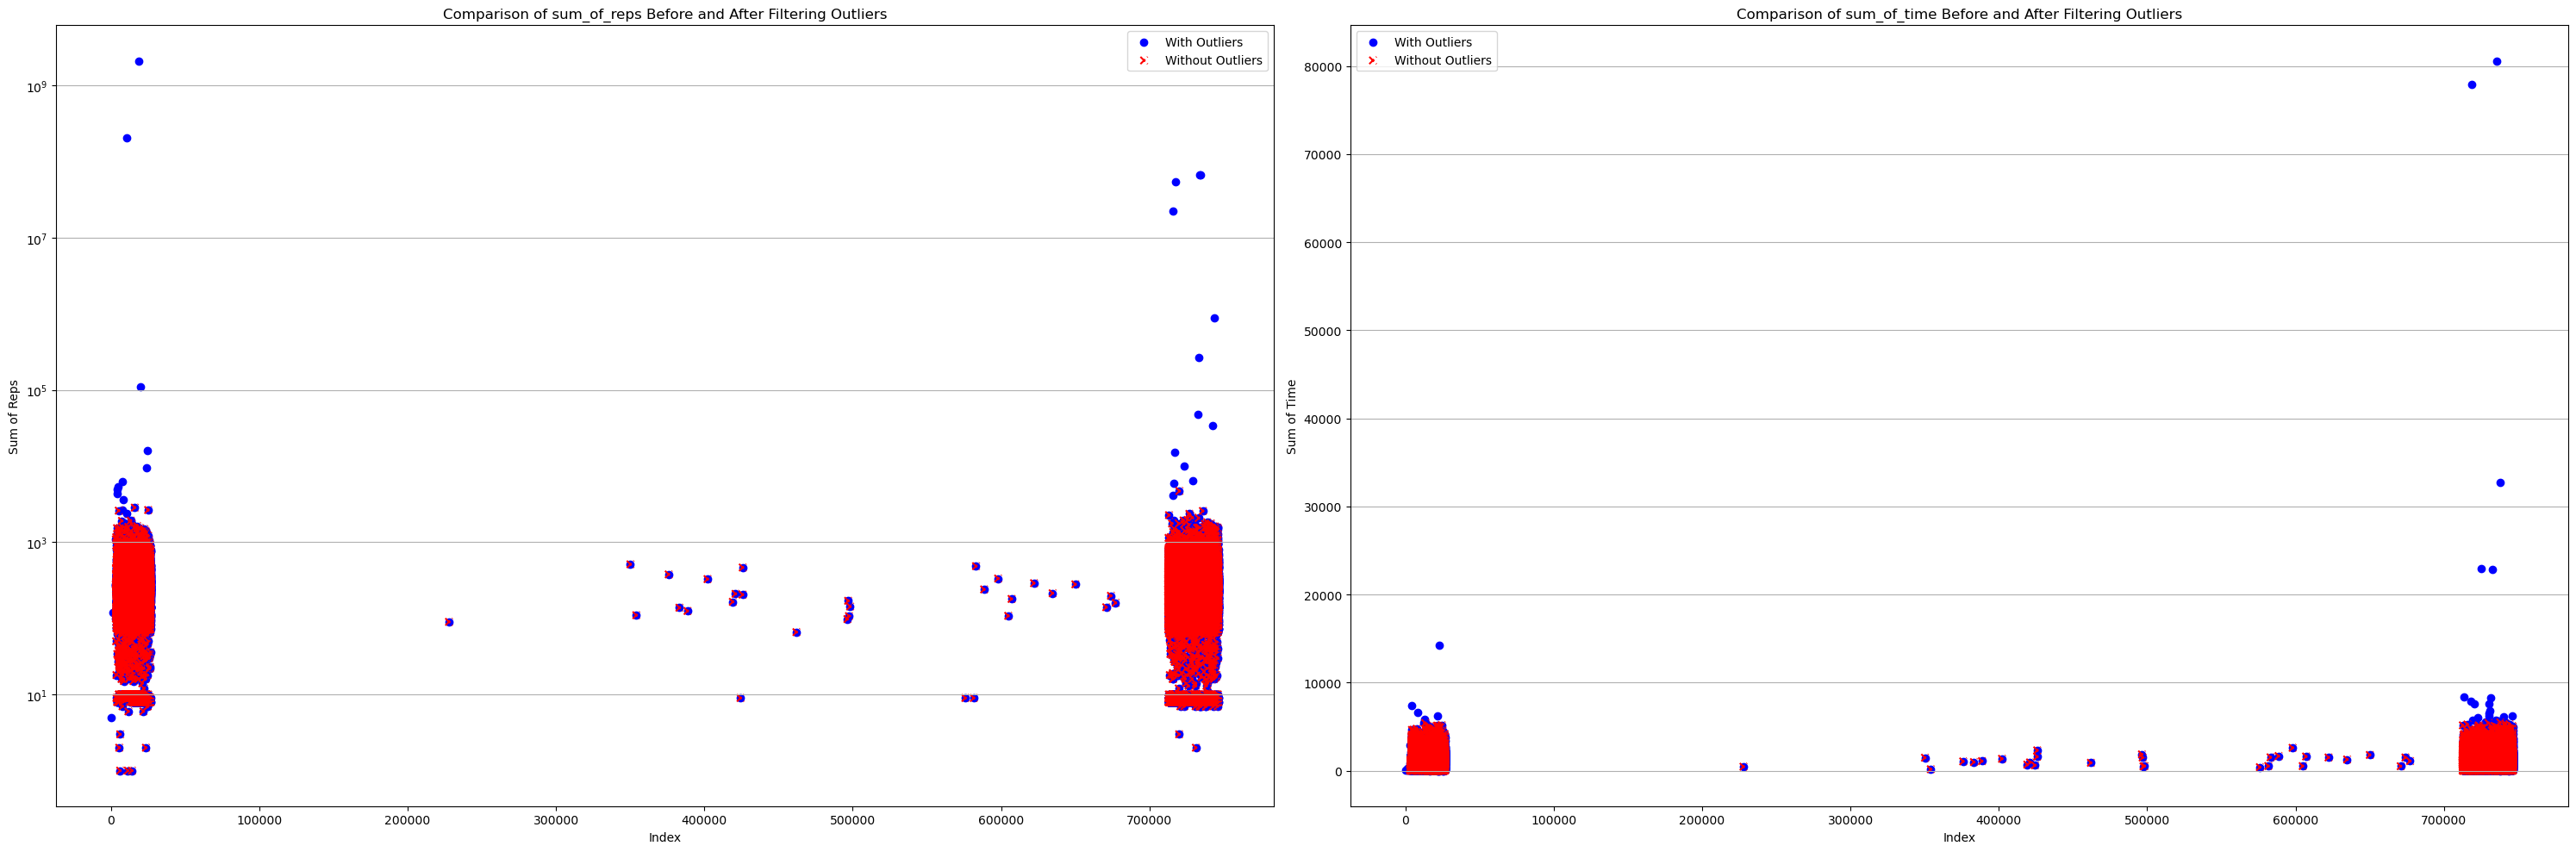

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# Plot sum_of_reps before and after filtering outliers
axs[0].scatter(df_series_recalculated.index, df_series_recalculated.sum_of_reps, label='With Outliers', color='blue', marker='o', linestyle='-')
axs[0].scatter(df_filtered.index, df_filtered.sum_of_reps, label='Without Outliers', color='red', marker='x', linestyle='--')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Sum of Reps')
axs[0].set_title('Comparison of sum_of_reps Before and After Filtering Outliers')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].grid(axis='y')

# Plot sum_of_time before and after filtering outliers
axs[1].scatter(df_series_recalculated.index, df_series_recalculated.sum_of_time, label='With Outliers', color='blue', marker='o', linestyle='-')
axs[1].scatter(df_filtered.index, df_filtered.sum_of_time, label='Without Outliers', color='red', marker='x', linestyle='--')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Sum of Time')
axs[1].set_title('Comparison of sum_of_time Before and After Filtering Outliers')
axs[1].legend()
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()


----
----
----
----

## **Statistical Analysis of the Data**

### **Distribution Graphs - Histograms**

- **GRAPH 1: Histogram of Series Distribution per Training Session (``total_count_of_series_reps``)**

    - This chart is a histogram that shows how training sessions are distributed according to the number of series performed. Each bar represents the number of sessions that have a specific number of series, allowing for the visualization of the frequency of different amounts of series per session.

- **GRAPH 2: Histogram of Repetitions Distribution per Training Session (``sum_of_reps``)**

    - This chart is a histogram that shows how training sessions are distributed according to the number of repetitions performed. Each bar represents the number of sessions that have a specific number of repetitions, allowing for the visualization of the frequency of different amounts of repetitions per session.

- **GRAPH 3: Histogram of the Distribution of Total Time Spent on Exercises per Training Session (``sum_of_time``)**

    - The displayed graph is a histogram that shows the distribution of the total time spent on exercises per training session, measured in minutes. The x-axis represents the total time spent, while the y-axis shows the frequency of sessions that fall within each time range. The histogram helps in understanding the common duration of training sessions, with the average session time being around 22 minutes.

- **GRAPH 4: Histogram of the Distribution of Rest Time per Training Session (``Rest_sum_of_time_per_exercise``)**

    - The displayed graph is a histogram that shows the distribution of rest time per training session, measured in minutes. The x-axis represents the rest time, while the y-axis shows the frequency of sessions that fall within each rest time range. The histogram helps in understanding the common rest periods, with the average rest time being around 5.64 minutes.

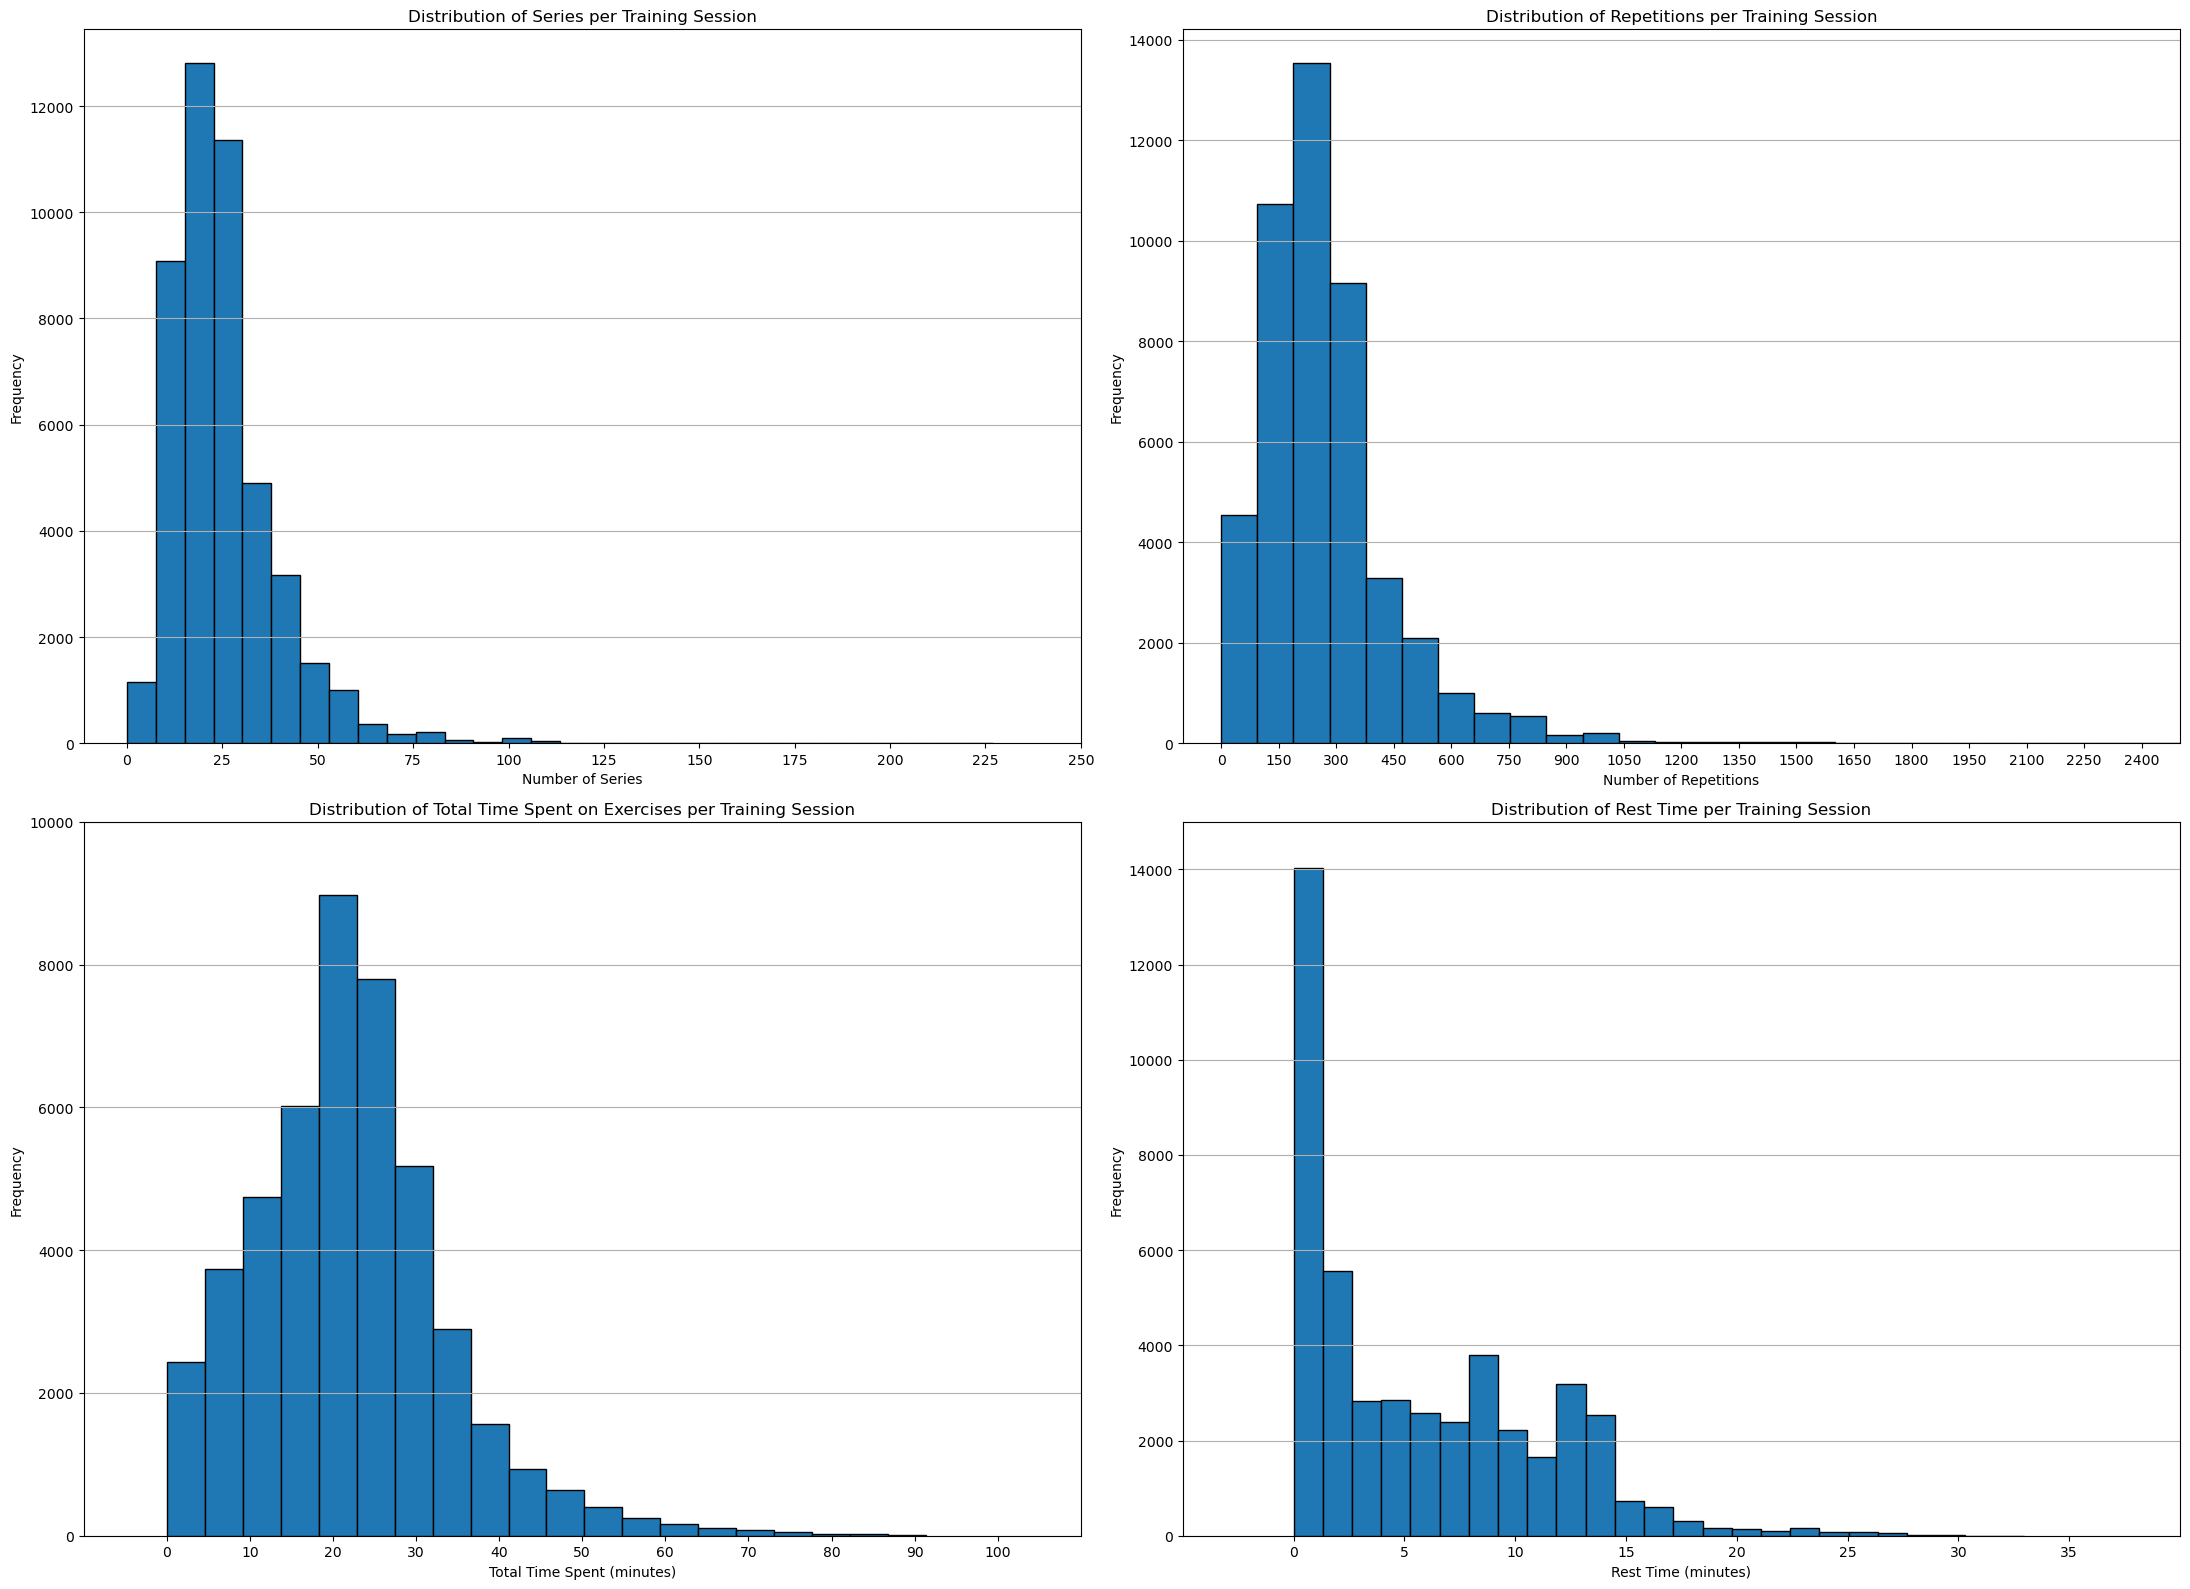

GRAPH 1: Distribution of Series per Training Session (total_count_of_series_reps)
    - Maximum value of series per training session: 227
    - Mean value of series per training session: 24.94800086918731
    - Median value of series per training session: 22.0
---------------------------------------------------------------------------------------------
GRAPH 2: Distribution of Repetitions per Training Session (sum_of_reps)
    - Maximum value of repetitions per training session: 4711.0
    - Mean value of repetitions per training session: 268.7180356366797
    - Median value of repetitions per training session: 240.0
---------------------------------------------------------------------------------------------
GRAPH 3: Distribution of Total Time Spent on Exercises per Training Session (sum_of_time)
    - Maximum value of total time per training session: 91.35 minutes
    - Mean value of total time per training session: 21.99771621034333 minutes
    - Median value of total time per train

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(22, 16))

# Plot 1: Distribution of Series per Training Session
axs[0, 0].hist(df_filtered['total_count_of_series_reps'], bins=30, edgecolor='black')
axs[0, 0].set_xlabel('Number of Series')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Distribution of Series per Training Session')
max_series = df_filtered['total_count_of_series_reps'].max()
axs[0, 0].set_xticks(np.arange(0, max_series + 25, 25))
axs[0, 0].grid(axis='y')

# Plot 2: Distribution of Repetitions per Training Session
axs[0, 1].hist(df_filtered['sum_of_reps'], bins=50, edgecolor='black')
axs[0, 1].set_xlabel('Number of Repetitions')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Distribution of Repetitions per Training Session')
max_reps = df_filtered['sum_of_reps'].max()
axs[0, 1].set_xticks(np.arange(0, max_reps + 150, 150))
axs[0, 1].set_xlim(-100, 2500)
axs[0, 1].grid(axis='y')

# Plot 3: Distribution of Total Time Spent on Exercises per Training Session
axs[1, 0].hist(df_filtered['sum_of_time'] / 60, bins=20, edgecolor='black')
axs[1, 0].set_xlabel('Total Time Spent (minutes)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Distribution of Total Time Spent on Exercises per Training Session')
max_time = df_filtered['sum_of_time'].max() / 60
axs[1, 0].set_xticks(np.arange(0, max_time + 10, 10))
axs[1, 0].set_ylim(0, 10000)
axs[1, 0].set_xlim(-10, 110)
axs[1, 0].grid(axis='y')

# Plot 4: Distribution of Rest Time per Training Session
axs[1, 1].hist(df_filtered['Rest_sum_of_time_per_exercise'] / 60, bins=25, edgecolor='black')
axs[1, 1].set_xlabel('Rest Time (minutes)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Rest Time per Training Session')
max_rest_time = df_filtered['Rest_sum_of_time_per_exercise'].max() / 60
axs[1, 1].set_xticks(np.arange(0, max_rest_time + 5, 5))
axs[1, 1].set_ylim(0, 15000)
axs[1, 1].set_xlim(-5, 40)
axs[1, 1].grid(axis='y')

plt.tight_layout()
plt.show()

print('GRAPH 1: Distribution of Series per Training Session (total_count_of_series_reps)')
print(f'    - Maximum value of series per training session: {df_filtered["total_count_of_series_reps"].max()}')
print(f'    - Mean value of series per training session: {df_filtered["total_count_of_series_reps"].mean()}')
print(f'    - Median value of series per training session: {df_filtered["total_count_of_series_reps"].median()}')
print('---------------------------------------------------------------------------------------------')
print('GRAPH 2: Distribution of Repetitions per Training Session (sum_of_reps)')
print(f'    - Maximum value of repetitions per training session: {df_filtered["sum_of_reps"].max()}')
print(f'    - Mean value of repetitions per training session: {df_filtered["sum_of_reps"].mean()}')
print(f'    - Median value of repetitions per training session: {df_filtered["sum_of_reps"].median()}')
print('---------------------------------------------------------------------------------------------')
print('GRAPH 3: Distribution of Total Time Spent on Exercises per Training Session (sum_of_time)')
print(f'    - Maximum value of total time per training session: {df_filtered["sum_of_time"].max() / 60} minutes')
print(f'    - Mean value of total time per training session: {df_filtered["sum_of_time"].mean() / 60} minutes')
print(f'    - Median value of total time per training session: {df_filtered["sum_of_time"].median() / 60} minutes')
print('---------------------------------------------------------------------------------------------')
print('GRAPH 4: Distribution of Rest Time per Training Session (Rest_sum_of_time_per_exercise)')
print(f'    - Maximum value of rest time per training session: {df_filtered["Rest_sum_of_time_per_exercise"].max() / 60} minutes')
print(f'    - Mean value of rest time per training session: {df_filtered["Rest_sum_of_time_per_exercise"].mean() / 60} minutes')
print(f'    - Median value of rest time per training session: {df_filtered["Rest_sum_of_time_per_exercise"].median() / 60} minutes')


- **GRAPH 1: Histogram of Training Frequency Distribution (``date``)**

    - This bar chart shows the number of training sessions conducted each month. The x-axis represents each month and year, while the y-axis indicates the number of training sessions. The graph provides insight into the monthly training patterns, revealing the highest frequency of training sessions and the overall distribution throughout the specified period. The mean training frequency per month is also displayed for better understanding of the data.

- **GRAPH 2: Histogram of Training Frequency Distribution per Week from January 2022 (``date``)**

    - This bar chart displays the number of training sessions conducted each week from January 2022. The x-axis represents each week, while the y-axis indicates the number of training sessions. The graph provides a detailed view of the weekly training patterns during this month, showing the highest frequency of training sessions and the overall weekly distribution. The maximum and mean training frequencies per week are also calculated to give a better understanding of the training intensity during this period.

    - The decision of selecting to show the distribution of training frequency per Week from January 2022 is due to it is the month that has the highest number of training sessions.


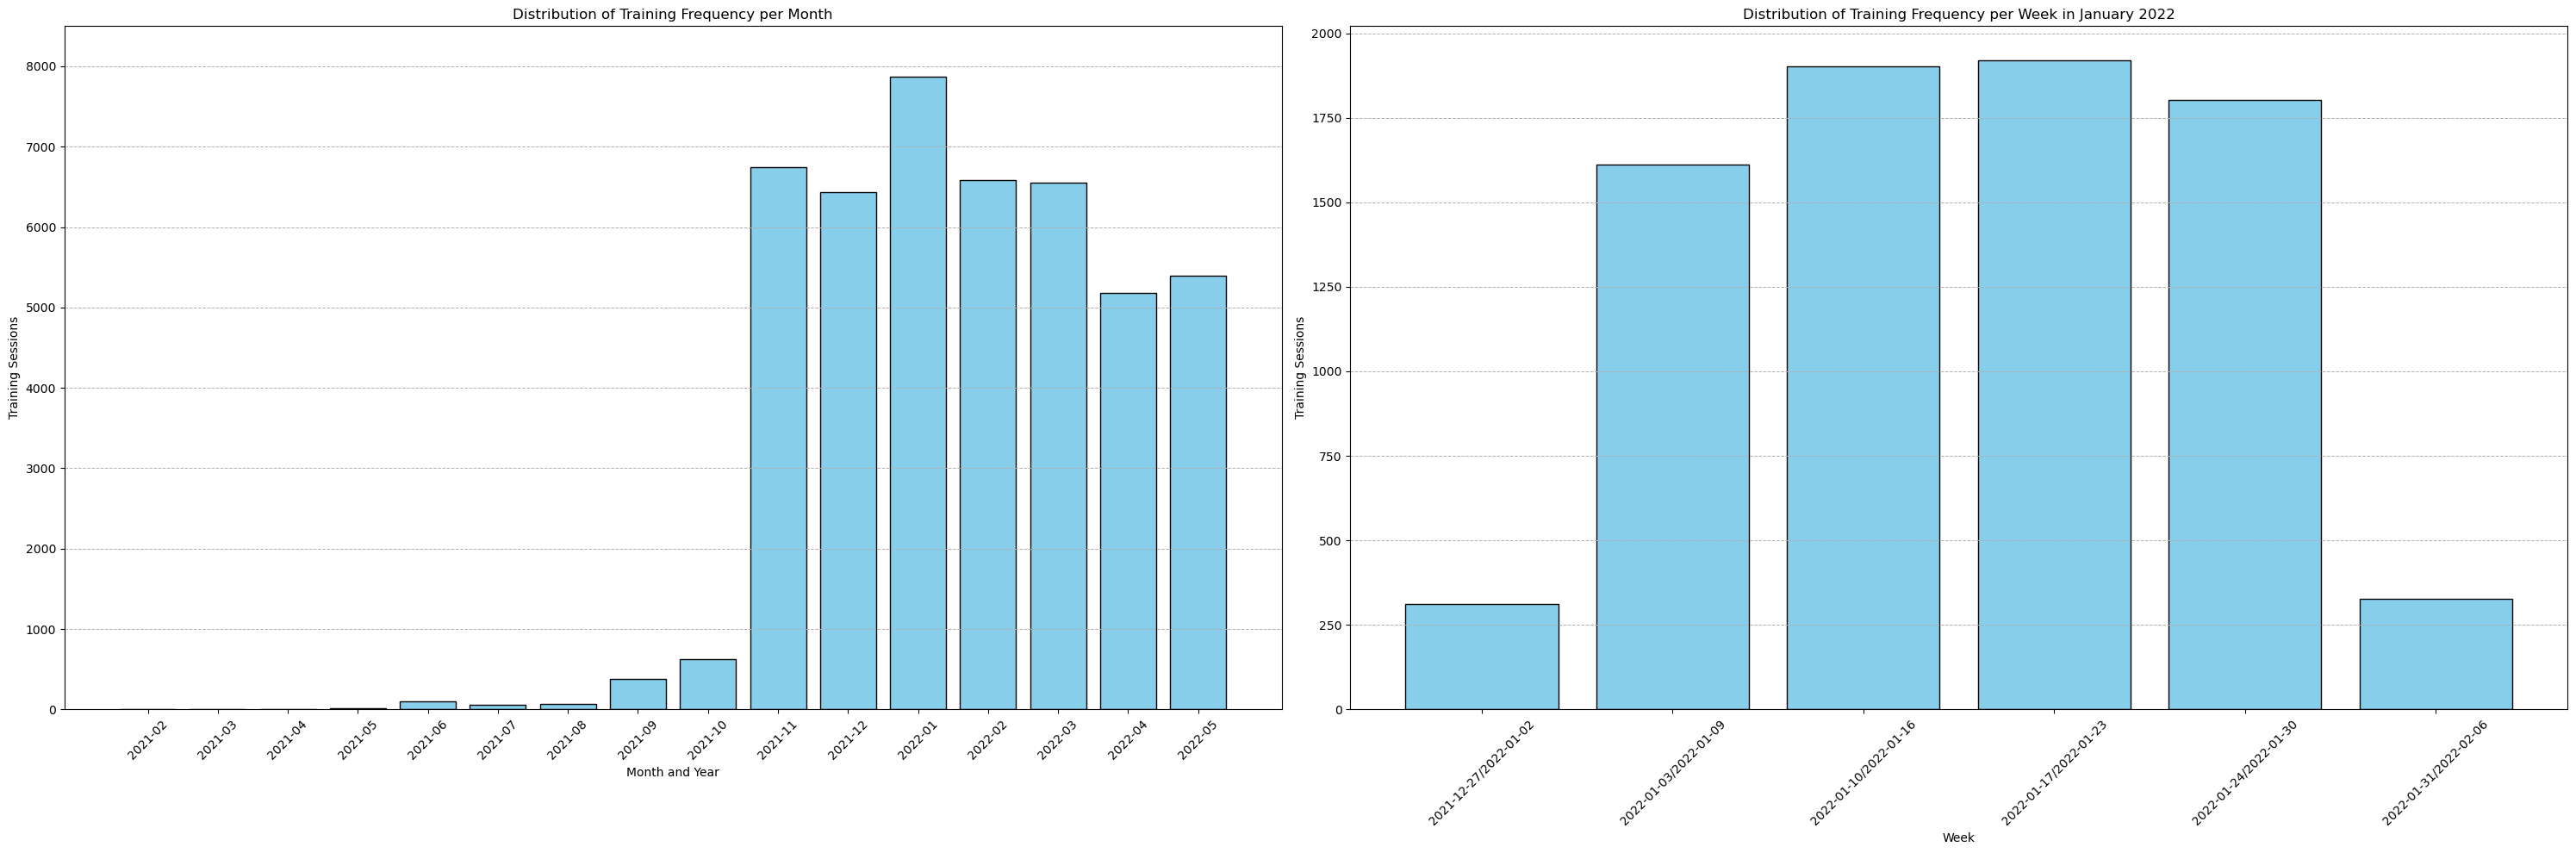

GRAPH 1: Distribution of Training Frequency per Month
month
2021-02       1
2021-03       7
2021-04       7
2021-05      15
2021-06     102
2021-07      62
2021-08      69
2021-09     376
2021-10     625
2021-11    6744
2021-12    6437
2022-01    7873
2022-02    6580
2022-03    6552
2022-04    5179
2022-05    5391
Freq: M, dtype: int64
------------------------------------------------------------------------------
GRAPH 2: Distribution of Training Frequency per Week in January 2022
week
2021-12-27/2022-01-02     311
2022-01-03/2022-01-09    1611
2022-01-10/2022-01-16    1901
2022-01-17/2022-01-23    1921
2022-01-24/2022-01-30    1803
2022-01-31/2022-02-06     326
Freq: W-SUN, dtype: int64


In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the number of training sessions per month
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['month'] = df_filtered['date'].dt.to_period('M')
training_frequency_per_month = df_filtered.groupby('month').size()

# Filter data for January 2022
filtered_df = df_filtered[(df_filtered['date'] >= '2022-01-01') & (df_filtered['date'] <= '2022-01-31')]

# Calculate the number of training sessions per week
filtered_df['week'] = filtered_df['date'].dt.to_period('W')
training_frequency_per_week = filtered_df.groupby('week').size()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# Plot 1: Distribution of Training Frequency per Month
axs[0].bar(training_frequency_per_month.index.astype(str), training_frequency_per_month.values, edgecolor='black', color='skyblue', width=0.8)
axs[0].set_xlabel('Month and Year')
axs[0].set_ylabel('Training Sessions')
axs[0].set_title('Distribution of Training Frequency per Month')
axs[0].set_ylim(0, training_frequency_per_month.max() + 100)
axs[0].set_xticklabels(training_frequency_per_month.index.astype(str), rotation=45)
axs[0].grid(axis='y', linestyle='--', linewidth=0.7)
axs[0].set_ylim(0, 8500)

# Plot 2: Distribution of Training Frequency per Week in January 2022
axs[1].bar(training_frequency_per_week.index.astype(str), training_frequency_per_week.values, edgecolor='black', color='skyblue', width=0.8)
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Training Sessions')
axs[1].set_title('Distribution of Training Frequency per Week in January 2022')
axs[1].set_ylim(0, training_frequency_per_week.max() + 100)
axs[1].set_xticklabels(training_frequency_per_week.index.astype(str), rotation=45)
axs[1].grid(axis='y', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

print('GRAPH 1: Distribution of Training Frequency per Month')
print(training_frequency_per_month)
print('------------------------------------------------------------------------------')
print('GRAPH 2: Distribution of Training Frequency per Week in January 2022')
print(training_frequency_per_week)


----

### **Analysis Over Time - Line Graphs**

- **GRAPH 1: Total Number of Series per Training Sessions Over Time (``date`` & ``total_count_of_series_reps``)**

    - The graph aims to visualize the total number of series per training session over time, tracking the progression or changes in training intensity or frequency. By plotting the summed series counts against each session's date, it helps to identify trends, such as increases in workout intensity or periods of rest, as well as any seasonal or periodic patterns in training behavior. This visualization is particularly useful for monitoring training loads and planning adjustments to workout schedules based on past activity.

- **GRAPH 2: Total Repetitions per Training Session Over Time (``date`` & ``sum_of_reps``)**

    - This graph is designed to illustrate the total number of repetitions performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

- **GRAPH 3: Total Duration per Training Session Over Time (``date`` & ``sum_of_time``)**

    - This graph is designed to illustrate the total time performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training time intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

- **GRAPH 4: Total Rest Time per Training Session Over Time (``date`` & ``Rest_sum_of_time_per_exercise``)**

    - This graph is designed to illustrate the total rest time performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training rest time intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

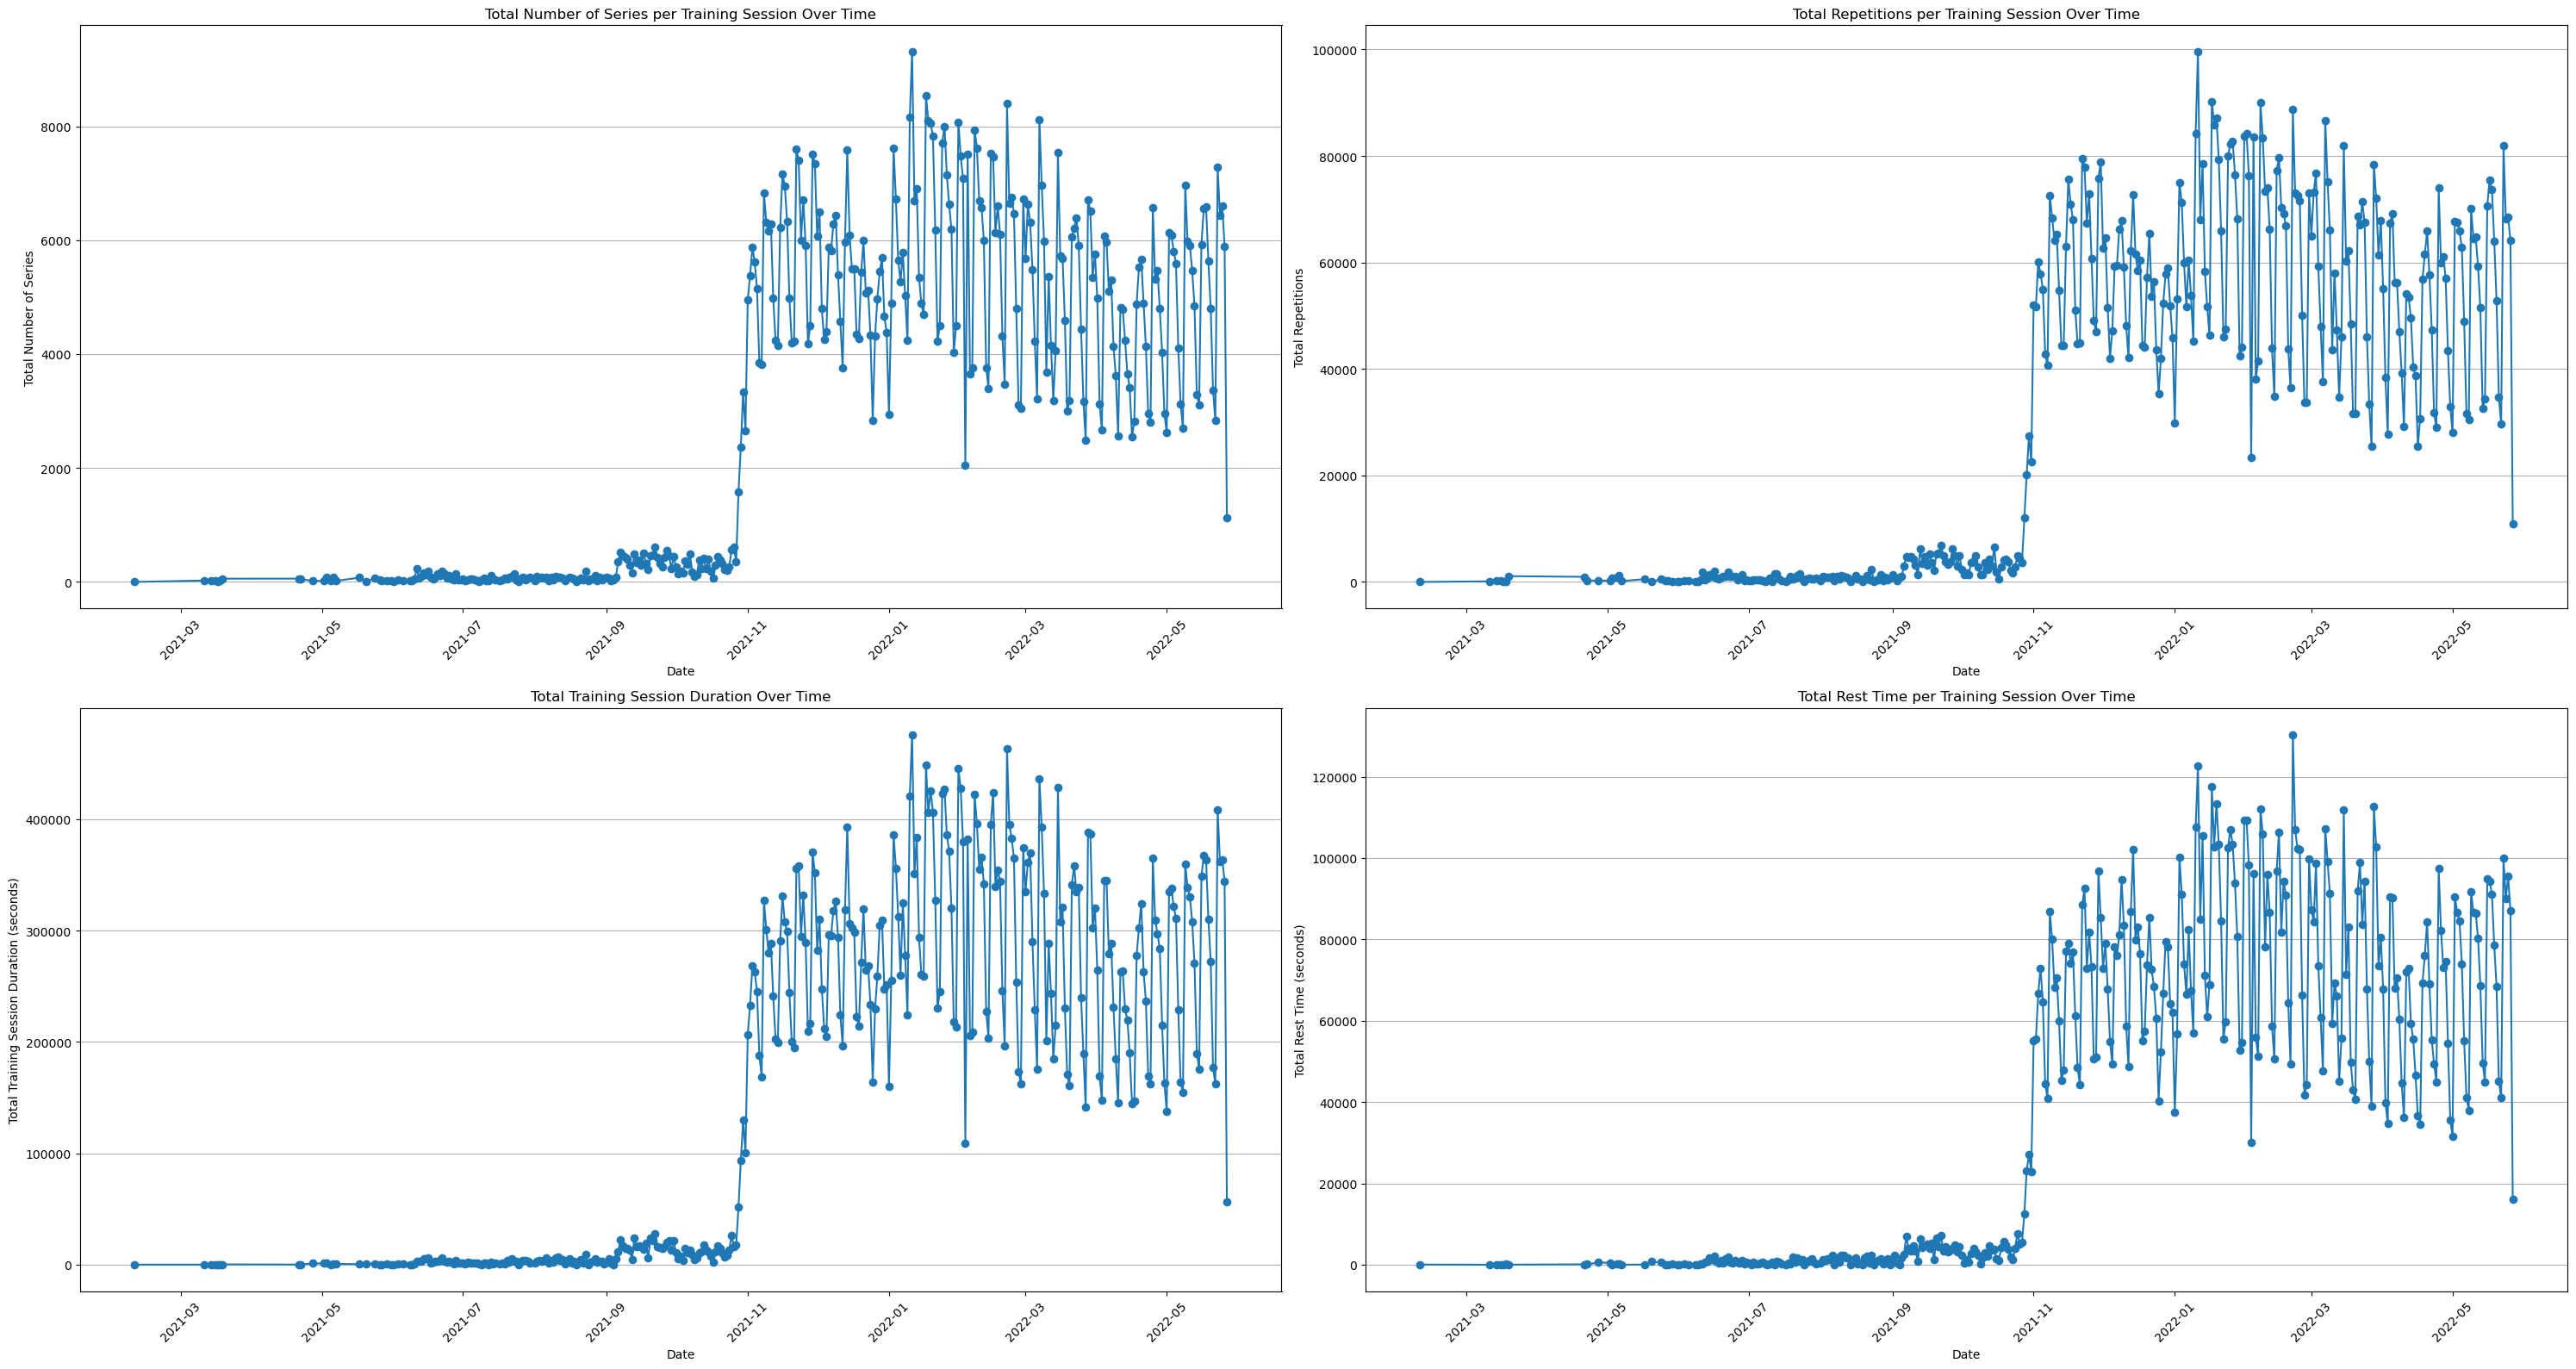

IMPORTANT ASPECT!
It is important to mention that each of the values (data points) are referring to the summatory amount of series, repetitions, duration, or rest time
of all the training sessions that have been carried out during that specific day.

GRAPH 1: Total Number of Series per Training Session Over Time
    - Maximum Value for Number of Series per Training Session Over Time: 9307
    - Mean Value for Number of Series per Training Session Over Time: 3053.476063829787
    - Median Value for Number of Series per Training Session Over Time: 3146.0
---------------------------------------------------------------------------------------------------------------------------------------
GRAPH 2: Total Repetitions per Training Session Over Time
    - Maximum Value for Number of Repetitions per Training Session Over Time: 99562.0
    - Mean Value for Number of Repetitions per Training Session Over Time: 32889.37234042553
    - Median Value for Number of Repetitions per Training Session Ov

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Plot 1: Total Number of Series per Training Session Over Time
series_over_time = df_filtered.groupby('date')['total_count_of_series_reps'].sum()

# Plot 2: Total Repetitions per Training Session Over Time
reps_over_time = df_filtered.groupby('date')['sum_of_reps'].sum()

# Plot 3: Total Training Session Duration Over Time
training_session_duration_over_time = df_filtered.groupby('date')['sum_of_time'].sum()

# Plot 4: Total Rest Time per Training Session Over Time
rest_time_over_time = df_filtered.groupby('date')['Rest_sum_of_time_per_exercise'].sum()

fig, axs = plt.subplots(2, 2, figsize=(30, 16))

# Subplot 1
axs[0, 0].plot(series_over_time.index, series_over_time.values, marker='o', linestyle='-')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Total Number of Series')
axs[0, 0].set_title('Total Number of Series per Training Session Over Time')
axs[0, 0].grid(axis='y')
axs[0, 0].tick_params(axis='x', rotation=45)

# Subplot 2
axs[0, 1].plot(reps_over_time.index, reps_over_time.values, marker='o', linestyle='-')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Total Repetitions')
axs[0, 1].set_title('Total Repetitions per Training Session Over Time')
axs[0, 1].grid(axis='y')
axs[0, 1].tick_params(axis='x', rotation=45)

# Subplot 3
axs[1, 0].plot(training_session_duration_over_time.index, training_session_duration_over_time.values, marker='o', linestyle='-')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Total Training Session Duration (seconds)')
axs[1, 0].set_title('Total Training Session Duration Over Time')
axs[1, 0].grid(axis='y')
axs[1, 0].tick_params(axis='x', rotation=45)

# Subplot 4
axs[1, 1].plot(rest_time_over_time.index, rest_time_over_time.values, marker='o', linestyle='-')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Total Rest Time (seconds)')
axs[1, 1].set_title('Total Rest Time per Training Session Over Time')
axs[1, 1].grid(axis='y')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print('IMPORTANT ASPECT!')
print('It is important to mention that each of the values (data points) are referring to the summatory amount of series, repetitions, duration, or rest time')
print('of all the training sessions that have been carried out during that specific day.\n')

print('GRAPH 1: Total Number of Series per Training Session Over Time')
print(f'    - Maximum Value for Number of Series per Training Session Over Time: {series_over_time.max()}')
print(f'    - Mean Value for Number of Series per Training Session Over Time: {series_over_time.mean()}')
print(f'    - Median Value for Number of Series per Training Session Over Time: {series_over_time.median()}')
print('---------------------------------------------------------------------------------------------------------------------------------------')
print('GRAPH 2: Total Repetitions per Training Session Over Time')
print(f'    - Maximum Value for Number of Repetitions per Training Session Over Time: {reps_over_time.max()}')
print(f'    - Mean Value for Number of Repetitions per Training Session Over Time: {reps_over_time.mean()}')
print(f'    - Median Value for Number of Repetitions per Training Session Over Time: {reps_over_time.median()}')
print('---------------------------------------------------------------------------------------------------------------------------------------')
print('GRAPH 3: Total Training Session Duration Over Time')
print(f'    - Maximum Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.max() / 60} minutes  //  {(training_session_duration_over_time.max() / 60) / 60} hours')
print(f'    - Mean Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.mean() / 60} minutes  //  {(training_session_duration_over_time.mean() / 60) / 60} hours')
print(f'    - Median Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.median() / 60} minutes  //  {(training_session_duration_over_time.median() / 60) / 60} hours')
print('---------------------------------------------------------------------------------------------------------------------------------------')
print('GRAPH 4: Total Rest Time per Training Session Over Time')
print(f'    - Maximum Value for Rest Time per Training Session Over Time: {rest_time_over_time.max() / 60} minutes  //  {(rest_time_over_time.max() / 60) / 60} hours')
print(f'    - Mean Value for Rest Time per Training Session Over Time: {rest_time_over_time.mean() / 60} minutes  //  {(rest_time_over_time.mean() / 60) / 60} hours')
print(f'    - Median Value for Rest Time per Training Session Over Time: {rest_time_over_time.median() / 60} minutes  //  {(rest_time_over_time.median() / 60) / 60} hours')

---

### **Box Plot Analysis - Detection of Outliers**

- **GRAPH 1: Box Plot of Total Series per Training Session (``total_count_of_series_reps``)**

    - This box plot visualizes the distribution of the total number of series performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the number of series per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low numbers of series in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

- **GRAPH 2: Box Plot of Total Repetitions per Training Session (``sum_of_reps``)**

    - This box plot visualizes the distribution of the total number of repetitions performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the number of repetitions per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low numbers of repetitions in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

- **GRAPH 3: Box Plot of Total Time per Training Session (``sum_of_time``)**

    - This box plot visualizes the distribution of the total time performed in each training session (this includes time doing exercise and rest time). The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the time per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low times in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

- **GRAPH 4: Box Plot of Rest Time per Training Session (``Rest_sum_of_time_per_exercise``)**

    - This box plot visualizes the distribution of the total rest time performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the rest time per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low rest times in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

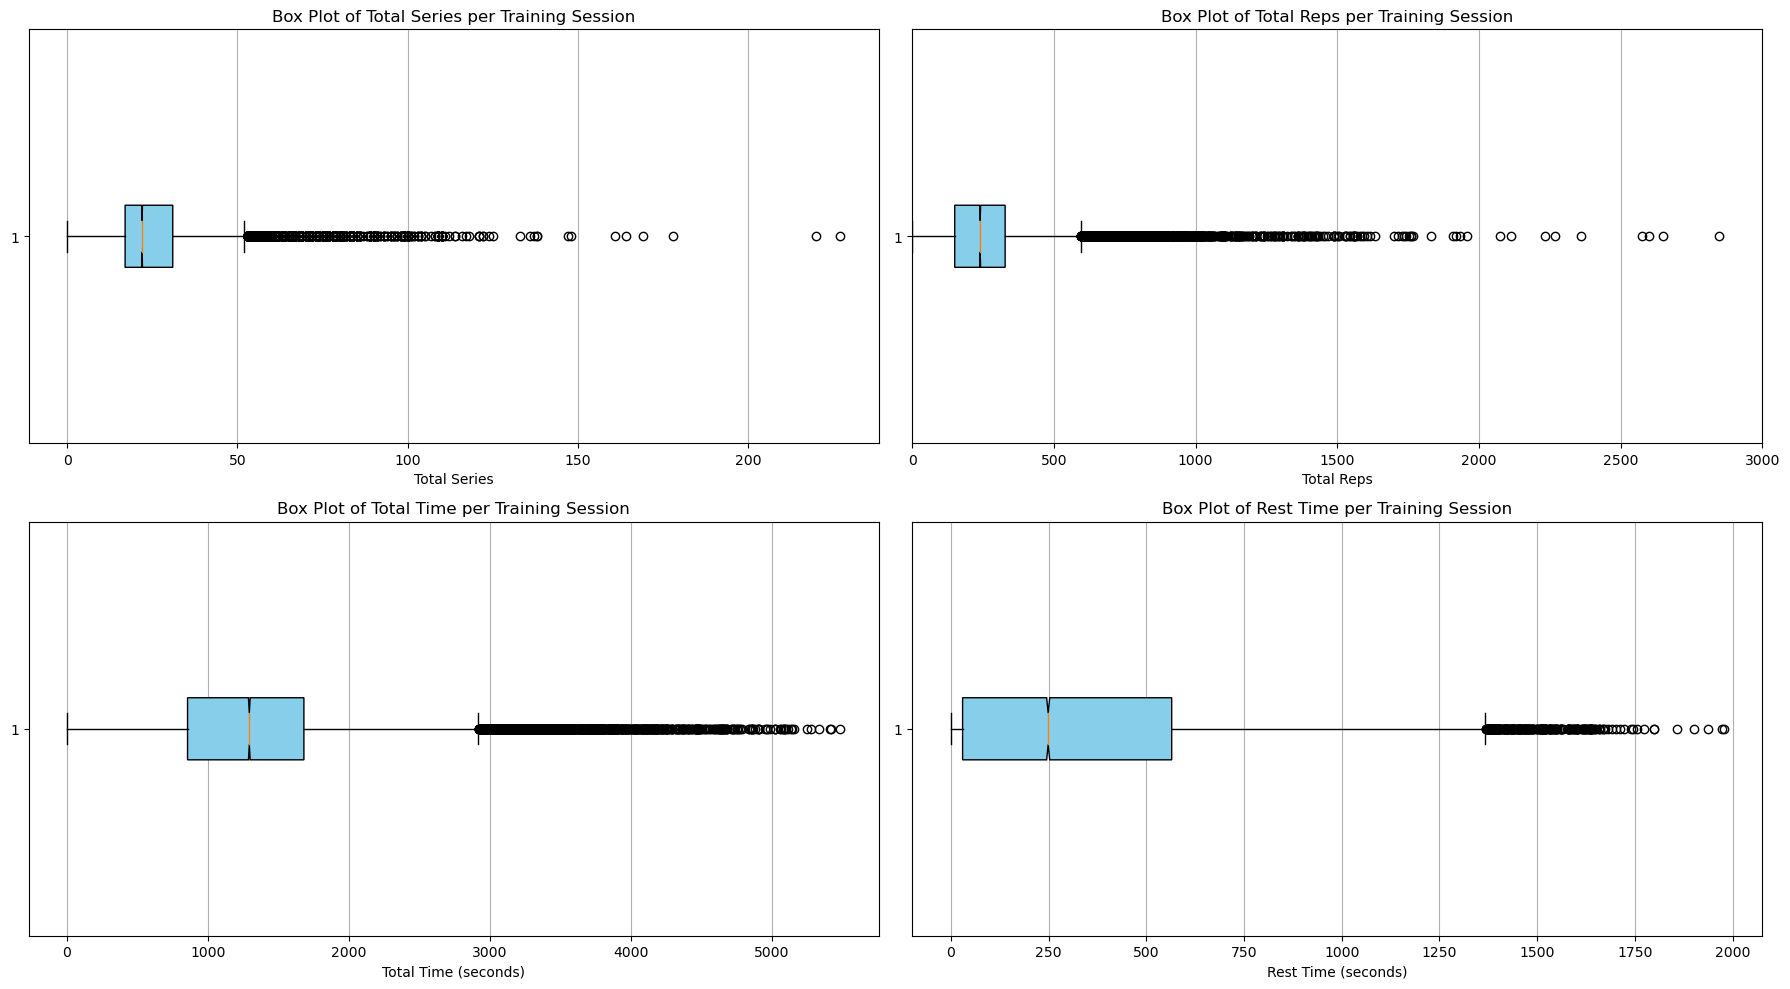

GRAPH 1: Box Plot of Total Series per Training Session
    - The maximum number of series per training session is: 227 series
    - The mean number of series per training session is: 24.94800086918731 series
    - The median number of series per training session is: 22.0 series
--------------------------------------------------------------------------------------------------
GRAPH 2: Box Plot of Total Reps per Training Session
    - The maximum number of repetitions per training session is: 4711.0 reps
    - The mean number of repetitions per training session is: 268.7180356366797 reps
    - The median number of repetitions per training session is: 240.0 reps

It is important to know that there exists one more outlier in the graph, at 4711, but it has to be added an x-axis limit 
in order to have a better interpretability of the graph displayed.
--------------------------------------------------------------------------------------------------
GRAPH 3: Box Plot of Total Time per Trainin

In [39]:
import matplotlib.pyplot as plt

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Define the data for each subplot
total_count_of_series_reps = df_filtered['total_count_of_series_reps']
sum_of_reps = df_filtered['sum_of_reps']
sum_of_time = df_filtered['sum_of_time']
rest_time = df_filtered['Rest_sum_of_time_per_exercise']

fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Box Plot of Total Series per Training Session
axs[0, 0].boxplot(total_count_of_series_reps, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
axs[0, 0].set_xlabel('Total Series')
axs[0, 0].set_title('Box Plot of Total Series per Training Session')
axs[0, 0].grid(axis='x')

# Plot 2: Box Plot of Total Reps per Training Session
axs[0, 1].boxplot(sum_of_reps, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
axs[0, 1].set_xlabel('Total Reps')
axs[0, 1].set_title('Box Plot of Total Reps per Training Session')
axs[0, 1].set_xlim(0, 3000)
axs[0, 1].grid(axis='x')

# Plot 3: Box Plot of Total Time per Training Session
axs[1, 0].boxplot(sum_of_time, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
axs[1, 0].set_xlabel('Total Time (seconds)')
axs[1, 0].set_title('Box Plot of Total Time per Training Session')
axs[1, 0].grid(axis='x')

# Plot 4: Box Plot of Rest Time per Training Session
axs[1, 1].boxplot(rest_time, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
axs[1, 1].set_xlabel('Rest Time (seconds)')
axs[1, 1].set_title('Box Plot of Rest Time per Training Session')
axs[1, 1].grid(axis='x')

plt.tight_layout()
plt.show()

print('GRAPH 1: Box Plot of Total Series per Training Session')
print(f'    - The maximum number of series per training session is: {total_count_of_series_reps.max()} series')
print(f'    - The mean number of series per training session is: {total_count_of_series_reps.mean()} series')
print(f'    - The median number of series per training session is: {total_count_of_series_reps.median()} series')
print('--------------------------------------------------------------------------------------------------')
print('GRAPH 2: Box Plot of Total Reps per Training Session')
print(f'    - The maximum number of repetitions per training session is: {sum_of_reps.max()} reps')
print(f'    - The mean number of repetitions per training session is: {sum_of_reps.mean()} reps')
print(f'    - The median number of repetitions per training session is: {sum_of_reps.median()} reps')
print('\nIt is important to know that there exists one more outlier in the graph, at 4711, but it has to be added an x-axis limit \nin order to have a better interpretability of the graph displayed.')
print('--------------------------------------------------------------------------------------------------')
print('GRAPH 3: Box Plot of Total Time per Training Session')
print(f'    - The maximum time of a training session is: {sum_of_time.max() / 60} minutes')
print(f'    - The mean time of a training session is: {sum_of_time.mean() / 60} minutes')
print(f'    - The median time of a training session is: {sum_of_time.median() / 60} minutes')
print('--------------------------------------------------------------------------------------------------')
print('GRAPH 4: Box Plot of Rest Time per Training Session')
print(f'    - The maximum rest time is: {rest_time.max() / 60} minutes')
print(f'    - The mean rest time is: {rest_time.mean() / 60} minutes')
print(f'    - The median rest time is: {rest_time.median() / 60} minutes')


----

### **Additional Analysis**

- **GRAPH 1: Training Session with Highest Number of Series (``total_count_of_series_reps``)**

    - This graph aims to highlight the training sessions with the highest number of series performed. By displaying the top 10 sessions with the most series, it provides insight into the most intensive training sessions. The y-axis represents the session IDs, and the x-axis shows the number of series, allowing for easy identification of the sessions with the highest volume of work.

- **GRAPH 2: Training Session with Highest Rest Time (``Rest_sum_of_time_per_exercise``)**

    - This graph aims to highlight the training sessions with the highest rest times and provide a context for these values by displaying the overall average rest time. By focusing on the top 10 sessions with the longest rest periods, the graph helps in identifying outliers or particularly significant rest intervals in the dataset. The red dashed line indicating the mean rest time serves as a reference point to compare these top values against the typical rest duration observed across all sessions. This visualization can be useful for trainers or athletes to analyze and optimize rest periods during training.

- **GRAPH 3 & GRAPH 4: Bar Chart of Average Reps per Series for Top Exercises & Bottom Exercises (columns ending in ``_reps`` and NOT ending in ``sum_of_reps`` or ``total_count_of_series_reps``)**

    - This graph aims to identify and display the top 10 & bottom 10 exercises with the highest average repetitions per series. By focusing on exercises that have significant repetition counts, it highlights which exercises typically involve more effort in terms of the number of repetitions, and the contrary in the case of the bottom 10 exercises. The graph excludes columns that represent summary data or series counts, ensuring that only individual exercise repetitions are considered. This visualization is useful for trainers and athletes to understand which exercises are performed with higher repetition counts on average, and also the lower repetition ones, helping in planning and adjusting workout routines for optimal training outcomes.

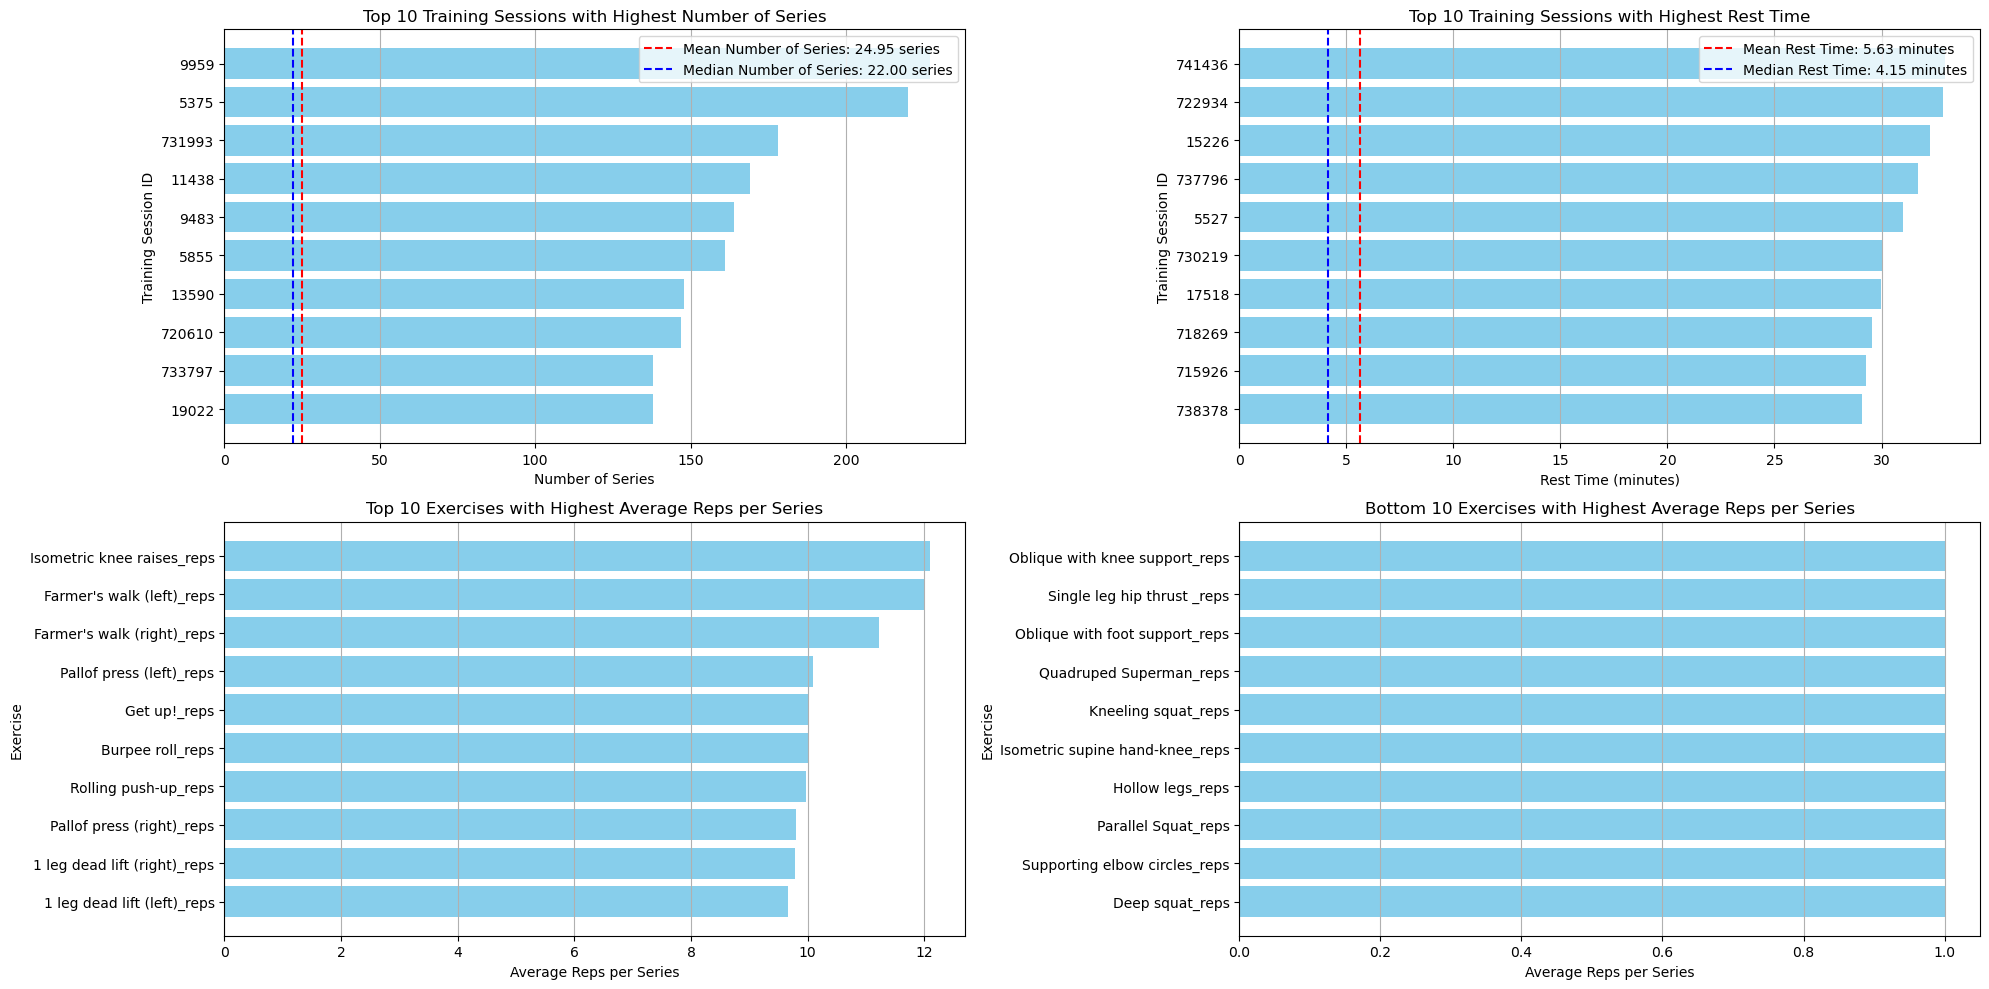

GRAPH 1: Top 10 Training Sessions with Highest Number of Series:
9959      227
5375      220
731993    178
11438     169
9483      164
5855      161
13590     148
720610    147
733797    138
19022     138
Name: total_count_of_series_reps, dtype: int64
--------------------------------------------------------------------------
GRAPH 2: Top 10 Training Sessions with Highest Rest Time (minutes)
741436    32.950000
722934    32.883333
15226     32.283333
737796    31.700000
5527      30.983333
730219    30.000000
17518     29.983333
718269    29.566667
715926    29.266667
738378    29.083333
Name: Rest_sum_of_time_per_exercise, dtype: float64
--------------------------------------------------------------------------
GRAPH 3: Top 10 Exercises with Highest Average Reps per Series
                         Exercise  Average Reps per Series
304    Isometric knee raises_reps                12.095238
408     Farmer's walk (left)_reps                12.000000
48     Farmer's walk (right)_reps      

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Data for Subplot 1
top_10_values_series = df_filtered['total_count_of_series_reps'].nlargest(10)
mean_total_count_of_series_reps = df_filtered['total_count_of_series_reps'].mean()
median_total_count_of_series_rep = df_filtered['total_count_of_series_reps'].median()

# Data for Subplot 2
top_10_values_rest = df_filtered['Rest_sum_of_time_per_exercise'].nlargest(10) / 60
mean_rest_time = df_filtered['Rest_sum_of_time_per_exercise'].mean() / 60 
median_rest_time = df_filtered['Rest_sum_of_time_per_exercise'].median() / 60

# Data for Subplot 3
exercise_columns = [col for col in df_filtered.columns if col.endswith('_reps') and 'sum_of_reps' not in col and 'total_count_of_series_reps' not in col]
mean_reps_per_exercise_top = pd.DataFrame(columns=['Exercise', 'Average Reps per Series'])

for col in exercise_columns:
    non_zero_values = df_filtered[col][df_filtered[col] != 0]
    if not non_zero_values.empty: 
        mean_reps = non_zero_values.mean()
        mean_reps_per_exercise_top = mean_reps_per_exercise_top.append({'Exercise': col, 'Average Reps per Series': mean_reps}, ignore_index=True)

mean_reps_per_exercise_top = mean_reps_per_exercise_top.sort_values(by='Average Reps per Series', ascending=False).head(10)

# Data for Subplot 4
mean_reps_per_exercise_bottom = pd.DataFrame(columns=['Exercise', 'Average Reps per Series'])

for col in exercise_columns:
    non_zero_values = df_filtered[col][df_filtered[col] != 0]
    if not non_zero_values.empty: 
        mean_reps = non_zero_values.mean()
        mean_reps_per_exercise_bottom = mean_reps_per_exercise_bottom.append({'Exercise': col, 'Average Reps per Series': mean_reps}, ignore_index=True)

mean_reps_per_exercise_bottom = mean_reps_per_exercise_bottom.sort_values(by='Average Reps per Series', ascending=True).head(10)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Plot 1: Top 10 Training Sessions with Highest Number of Series
axs[0, 0].barh(range(10), top_10_values_series.values, color='skyblue')
axs[0, 0].set_yticks(range(10))
axs[0, 0].set_yticklabels(top_10_values_series.index)
axs[0, 0].axvline(mean_total_count_of_series_reps, color='r', linestyle='--', label=f'Mean Number of Series: {mean_total_count_of_series_reps:.2f} series')
axs[0, 0].axvline(median_total_count_of_series_rep, color='b', linestyle='--', label=f'Median Number of Series: {median_total_count_of_series_rep:.2f} series')
axs[0, 0].set_xlabel('Number of Series')
axs[0, 0].set_ylabel('Training Session ID')
axs[0, 0].set_title('Top 10 Training Sessions with Highest Number of Series')
axs[0, 0].grid(axis='x')
axs[0, 0].legend()
axs[0, 0].invert_yaxis()

# Plot 2: Top 10 Training Sessions with Highest Rest Time
axs[0, 1].barh(range(10), top_10_values_rest.values, color='skyblue')
axs[0, 1].set_yticks(range(10))
axs[0, 1].set_yticklabels(top_10_values_rest.index)
axs[0, 1].axvline(mean_rest_time, color='r', linestyle='--', label=f'Mean Rest Time: {mean_rest_time:.2f} minutes')
axs[0, 1].axvline(median_rest_time, color='b', linestyle='--', label=f'Median Rest Time: {median_rest_time:.2f} minutes')
axs[0, 1].set_xlabel('Rest Time (minutes)')
axs[0, 1].set_ylabel('Training Session ID')
axs[0, 1].set_title('Top 10 Training Sessions with Highest Rest Time')
axs[0, 1].grid(axis='x')
axs[0, 1].legend()
axs[0, 1].invert_yaxis()

# Plot 3: Top 10 Exercises with Highest Average Reps per Series
axs[1, 0].barh(mean_reps_per_exercise_top['Exercise'], mean_reps_per_exercise_top['Average Reps per Series'], color='skyblue')
axs[1, 0].set_xlabel('Average Reps per Series')
axs[1, 0].set_ylabel('Exercise')
axs[1, 0].set_title('Top 10 Exercises with Highest Average Reps per Series')
axs[1, 0].grid(axis='x')
axs[1, 0].invert_yaxis()

# Plot 4: Bottom 10 Exercises with Highest Average Reps per Series
axs[1, 1].barh(mean_reps_per_exercise_bottom['Exercise'], mean_reps_per_exercise_bottom['Average Reps per Series'], color='skyblue')
axs[1, 1].set_xlabel('Average Reps per Series')
axs[1, 1].set_ylabel('Exercise')
axs[1, 1].set_title('Bottom 10 Exercises with Highest Average Reps per Series')
axs[1, 1].grid(axis='x')
axs[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print('GRAPH 1: Top 10 Training Sessions with Highest Number of Series:')
print(top_10_values_series)
print('--------------------------------------------------------------------------')
print('GRAPH 2: Top 10 Training Sessions with Highest Rest Time (minutes)')
print(top_10_values_rest)
print('--------------------------------------------------------------------------')
print('GRAPH 3: Top 10 Exercises with Highest Average Reps per Series')
print(mean_reps_per_exercise_top)
print('--------------------------------------------------------------------------')
print('GRAPH 4: Bottom 10 Exercises with Highest Average Reps per Series')
print(mean_reps_per_exercise_bottom)


- **GRAPH 1 & GRAPH 2: Violin Plot of Exercise Efficiency (Reps per Second) - Top 10 Exercises & Bottom 10 Exercises (columns ending in ``_reps`` and NOT ending in ``sum_of_reps`` or ``total_count_of_series_reps``)**

    - This violin plot visualizes the efficiency of different exercises, measured as the number of repetitions performed per second. It includes the top 10 exercises with the highest average efficiency. The plot aims to:

        - **Show Distribution**: Highlight the spread and density of efficiency values for each exercise.
        - **Identify Patterns**: Reveal any patterns or trends in how efficiently different exercises are performed.
        - **Compare Exercises**: Allow easy comparison of efficiency across the top 10 exercises.
        - **Highlight Variability**: Indicate the variability and consistency in exercise efficiency, with quartile lines providing additional context.

    - This visualization helps in understanding which exercises are performed more efficiently and how the efficiency varies for each exercise.

- **GRAPH 3: Pie Chart of Exercise Distribution by Series Count (``total_count_of_series_reps``)**

    - This pie chart visualizes the distribution of the top 10 exercises based on the number of series performed. Each segment of the pie represents a specific exercise, with the size of the segment corresponding to the proportion of series counts for that exercise. The chart provides an overview of which exercises are most frequently performed in terms of series, allowing trainers and athletes to quickly identify the most common exercises in their routines. This information can be useful for balancing workouts, identifying overused exercises, or highlighting those that may need more focus. The addition of a legend and percentage labels enhances the clarity and readability of the chart.

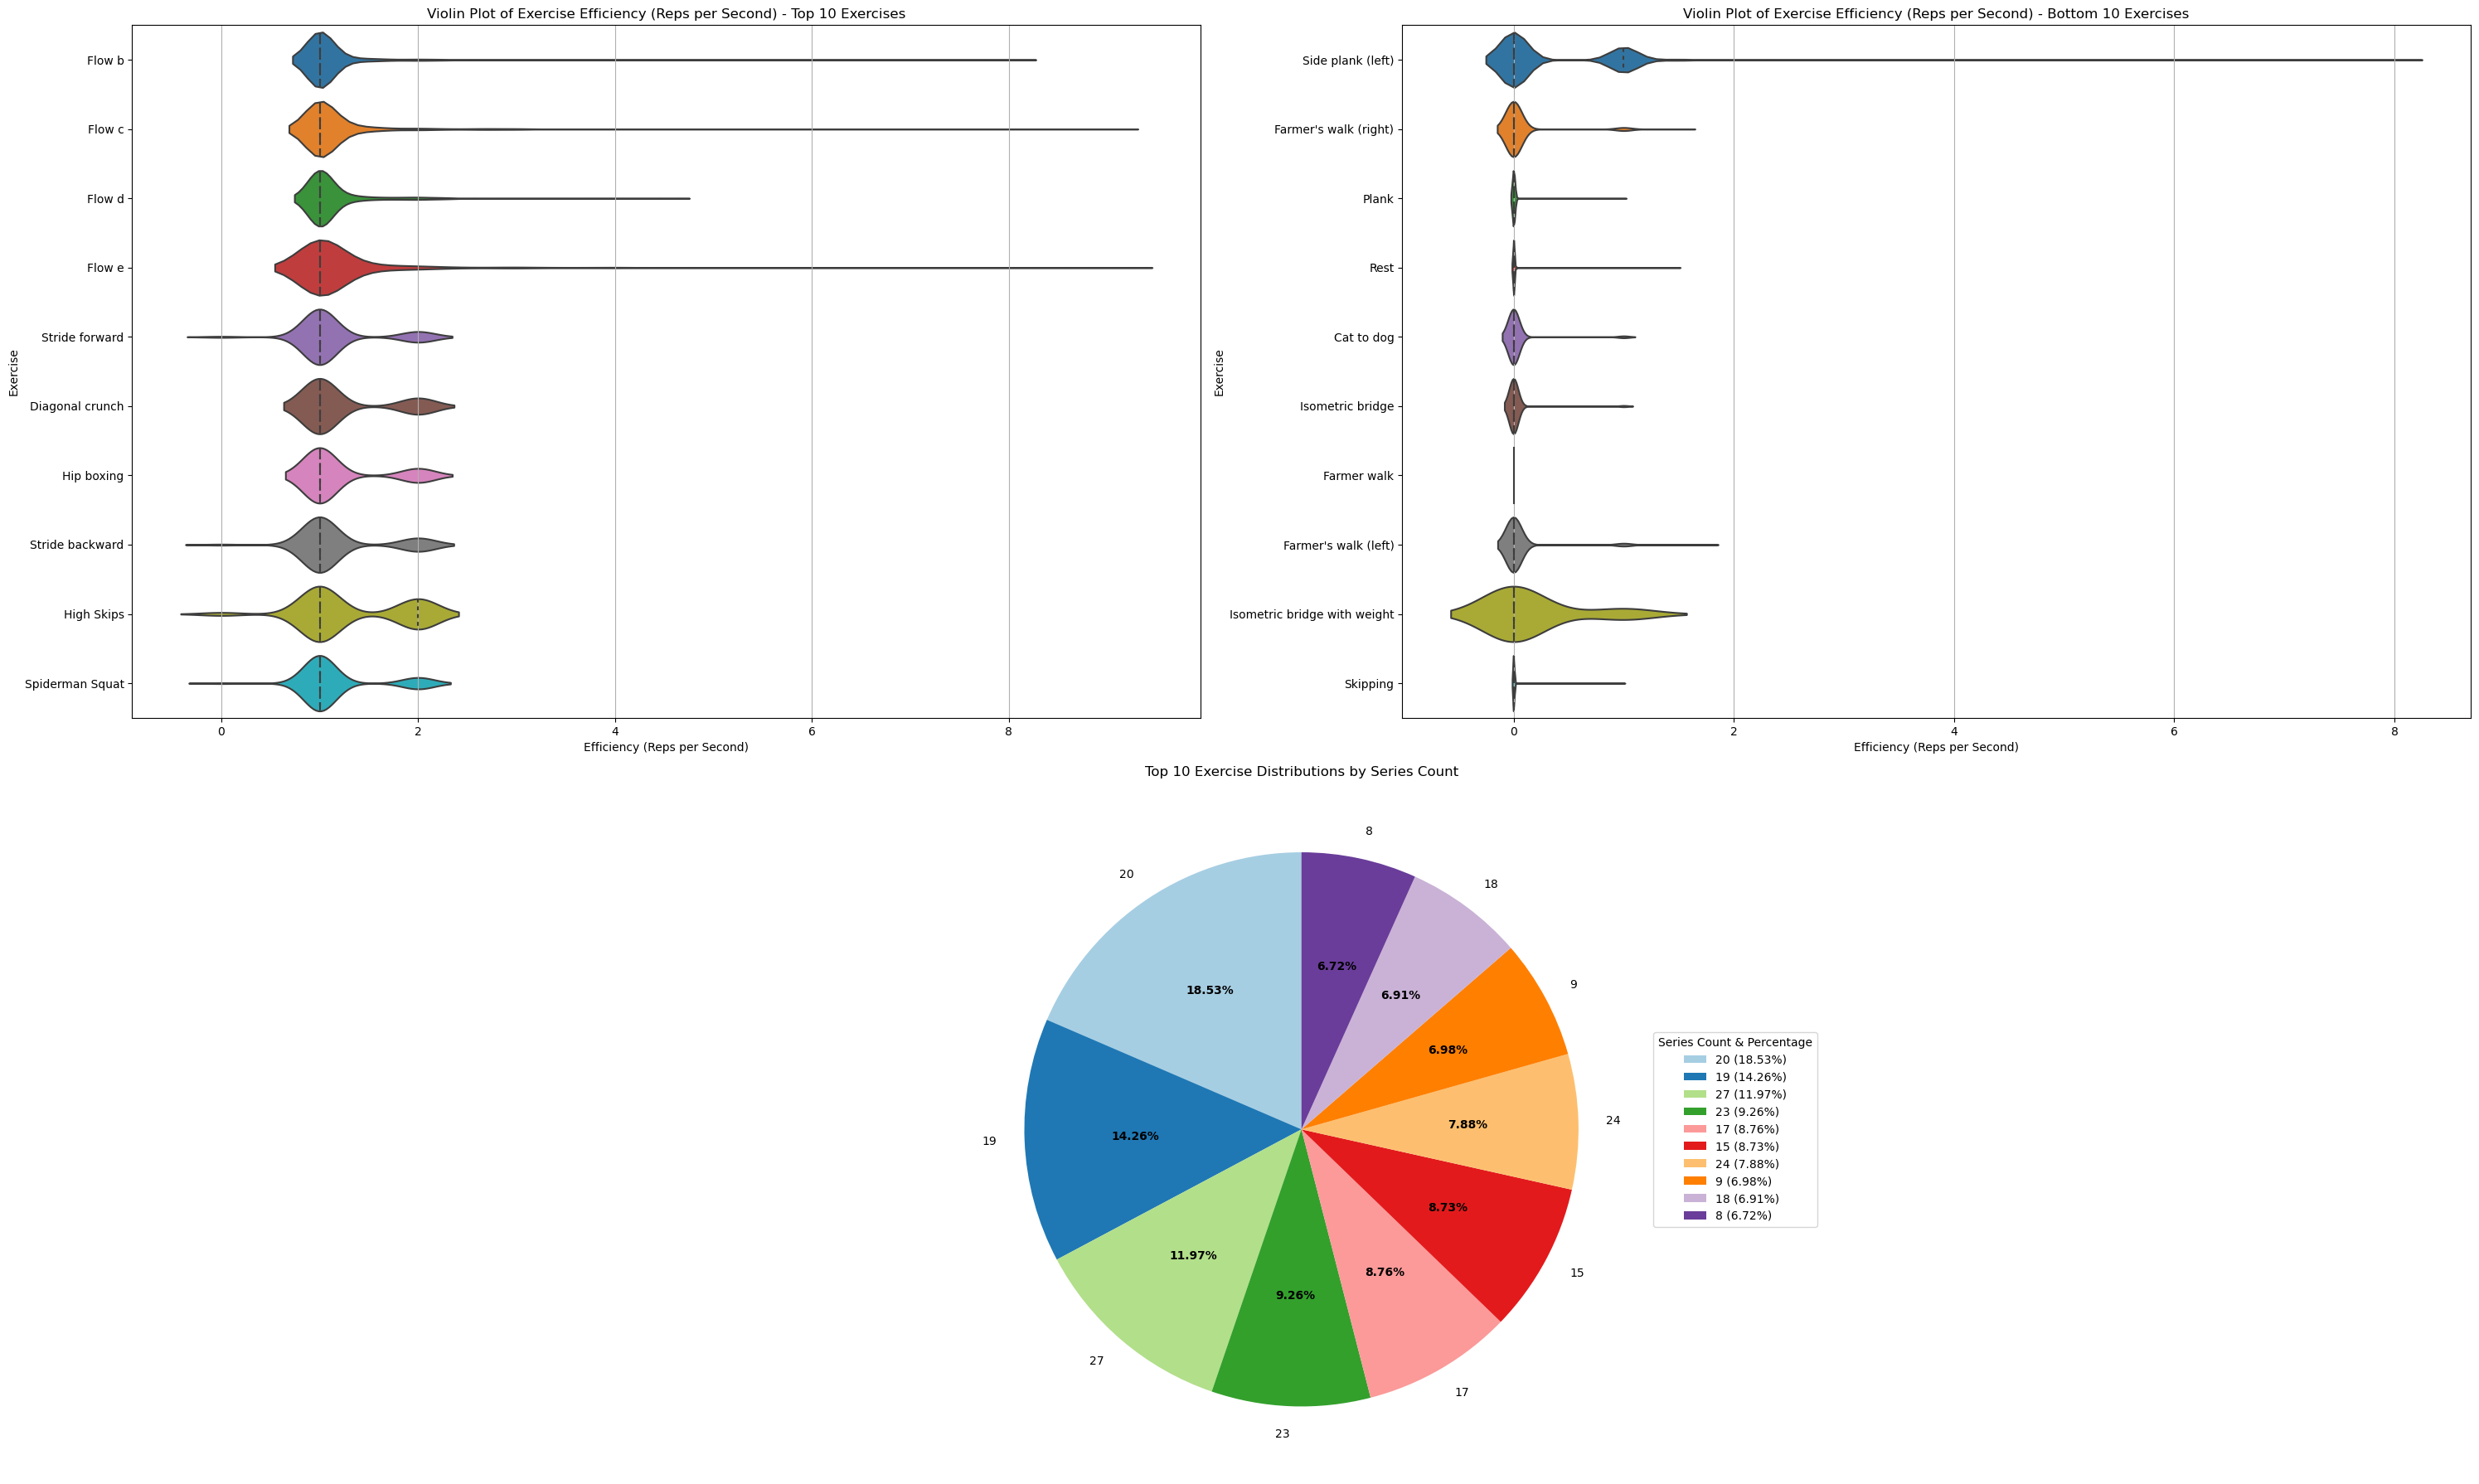

GRAPH 1: Top 10 exercises by mean efficiency
          Exercise  Mean Efficiency  Max Efficiency  Min Efficiency
0       High Skips         1.307692             2.0             0.0
1  Diagonal crunch         1.227273             2.0             1.0
2       Hip boxing         1.202899             2.0             1.0
3           Flow e         1.201096             9.0             1.0
4  Stride backward         1.176471             2.0             0.0
5  Spiderman Squat         1.156627             2.0             0.0
6   Stride forward         1.142857             2.0             0.0
7           Flow c         1.141122             9.0             1.0
8           Flow d         1.134606             4.5             1.0
9           Flow b         1.127107             8.0             1.0
---------------------------------------------------------------------------
GRAPH 2: Bottom 10 exercises by mean efficiency
                       Exercise  Mean Efficiency  Max Efficiency  Min Efficiency
0 

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Data setup
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Calculate Exercise Efficiency (Reps per Second)
efficiency_data = []
for col in df_filtered.columns:
    if col.endswith('_reps') and col != 'sum_of_reps' and col != 'total_count_of_series_reps':
        exercise_name = col.replace('_reps', '')
        time_col = exercise_name + '_time'
        if time_col in df_filtered.columns:
            reps = df_filtered[col]
            time = df_filtered[time_col]
            efficiency = reps / time
            efficiency_data.append(pd.DataFrame({'Exercise': [exercise_name] * len(efficiency), 'Efficiency': efficiency}))

efficiency_df = pd.concat(efficiency_data, ignore_index=True).dropna(subset=['Efficiency'])

mean_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].mean()
max_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].max()
min_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].min()

# Top 10 exercises by mean efficiency
top_10_exercises = mean_efficiency.nlargest(10).index
filtered_efficiency_top_df = efficiency_df[efficiency_df['Exercise'].isin(top_10_exercises)]

# Bottom 10 exercises by mean efficiency
bottom_10_exercises = mean_efficiency.nsmallest(10).index
filtered_efficiency_bottom_df = efficiency_df[efficiency_df['Exercise'].isin(bottom_10_exercises)]

# Calculate value counts for total_count_of_series_reps and get the top 10
exercise_series_counts = df_filtered['total_count_of_series_reps'].value_counts().head(10)
percentages = 100 * exercise_series_counts / exercise_series_counts.sum()
combined = pd.DataFrame({'count': exercise_series_counts, 'percentage': percentages}).sort_values(by='percentage', ascending=False)
legend_labels = [f"{count} ({percentage:.2f}%)" for count, percentage in zip(combined.index, combined['percentage'])]

# Plotting
fig = plt.figure(figsize=(30, 18))

# Subplot 1: Violin Plot of Exercise Efficiency - Top 10 Exercises
ax1 = fig.add_subplot(2, 2, 1)
sns.violinplot(data=filtered_efficiency_top_df, x='Efficiency', y='Exercise', scale='width', inner='quartile', ax=ax1)
ax1.set_xlabel('Efficiency (Reps per Second)')
ax1.set_ylabel('Exercise')
ax1.set_title('Violin Plot of Exercise Efficiency (Reps per Second) - Top 10 Exercises')
ax1.grid(axis='x')

# Subplot 2: Violin Plot of Exercise Efficiency - Bottom 10 Exercises
ax2 = fig.add_subplot(2, 2, 2)
sns.violinplot(data=filtered_efficiency_bottom_df, x='Efficiency', y='Exercise', scale='width', inner='quartile', ax=ax2)
ax2.set_xlabel('Efficiency (Reps per Second)')
ax2.set_ylabel('Exercise')
ax2.set_title('Violin Plot of Exercise Efficiency (Reps per Second) - Bottom 10 Exercises')
ax2.grid(axis='x')

# Subplot 3: Pie Chart of Top 10 Exercise Distributions by Series Count
ax3 = fig.add_subplot(2, 1, 2)
wedges, texts, autotexts = ax3.pie(
    combined['count'], 
    labels=combined.index, 
    autopct='%1.2f%%', 
    startangle=90,
    colors=plt.cm.Paired(np.arange(len(combined)))
)
ax3.set_title('Top 10 Exercise Distributions by Series Count')
ax3.legend(wedges, legend_labels, title="Series Count & Percentage", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")

plt.tight_layout()
plt.show()

# Top 10 exercises by mean efficiency
top_10_exercises = mean_efficiency.nlargest(10).index
top_10_data = {"Exercise": [], "Mean Efficiency": [], "Max Efficiency": [], "Min Efficiency": []}

for exercise in top_10_exercises:
    top_10_data["Exercise"].append(exercise)
    top_10_data["Mean Efficiency"].append(mean_efficiency[exercise])
    top_10_data["Max Efficiency"].append(max_efficiency[exercise])
    top_10_data["Min Efficiency"].append(min_efficiency[exercise])

# Bottom 10 exercises by mean efficiency
bottom_10_exercises = mean_efficiency.nsmallest(10).index
bottom_10_data = {"Exercise": [], "Mean Efficiency": [], "Max Efficiency": [], "Min Efficiency": []}

for exercise in bottom_10_exercises:
    bottom_10_data["Exercise"].append(exercise)
    bottom_10_data["Mean Efficiency"].append(mean_efficiency[exercise])
    bottom_10_data["Max Efficiency"].append(max_efficiency[exercise])
    bottom_10_data["Min Efficiency"].append(min_efficiency[exercise])

# Convert to DataFrames for better display
top_10_df = pd.DataFrame(top_10_data)
bottom_10_df = pd.DataFrame(bottom_10_data)

# Set display options to avoid truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print('GRAPH 1: Top 10 exercises by mean efficiency')
print(top_10_df)
print('---------------------------------------------------------------------------')
print('GRAPH 2: Bottom 10 exercises by mean efficiency')
print(bottom_10_df)



-----
-----
-----
-----

## Comparisons Regarding Objectives & Personal Information

In order to perform the proper comparisons regarding the specific objectives or goals that each user has, and regarding the personal information, firstly we have to join to the dataset those concrete rows.
For instance, some the comparisons that we are looking to make are:
- Comparison regarding the goal or objective that users have for their particular situation. (0 = Lose // 1 = Gain // 2 = Antiaging)
- Comparison regarding the gender of the users, in order to see  the distribution among those. (0 = Female // 1 = Male)
- Comparison regarding the body fat of the users, to explore the physical conditions that they have.
- Comparison regarding the age of the users, which could be an interesting approach to see how it is distributed.
- And more additional ones that are going to be displayed below.

In [26]:
# Read the dataset where we have the personal variables of the users, as the ones mentioned before.
users_info = pd.read_hdf('../data/flattened_database_merged_with_session_executions_v02.h5')
users_info.shape

(51355, 9186)

In [42]:
# Ensure users_info is a DataFrame
if isinstance(users_info, list):
    users_info = users_info[0]

# Select the proper columns for making the desired comparisons
selected_columns = users_info[['body_parts_focused', 'exercises_met_multiplier', 'exercises_muscles', 
'session_executions_difficulty_feedback', 'session_executions_discarded', 'session_executions_enjoyment_feedback', 'session_executions_imported', 
'sessions_calories', 'user_programs_active', 'user_programs_completed', 'users_gender', 'users_activity_level', 'users_body_type', 
'users_newsletter_subscription', 'users_sign_in_count', 'users_notifications_setting', 'users_training_days_setting', 'users_country', 'users_points', 
'users_best_weekly_streak', 'users_goal', 'users_date_of_birth', 'users_height', 'users_weight', 'users_body_fat', 'session_executions_summary_total_reps', 
'session_executions_summary_updated_at']]

# Assign the selected columns DataFrame to users_info
users_info = selected_columns

# Merge the dataframes
df_filtered_merged = df_filtered.merge(users_info, how='inner', left_index=True, right_index=True)
df_filtered_merged.shape


(46020, 8705)

In [ ]:
# Save the merged DataFrame to an CSV file
df_filtered_merged.to_csv('../data/filtered_merged_dataset_v1.csv')
print(df_filtered.head())

In [ ]:
df_filtered_merged = pd.read_csv('../data/filtered_merged_dataset_v1.csv')
df_filtered_merged.fillna(0, inplace=True)
df_filtered_merged.shape

#### **Comparisons with the Goal**

The primary purpose of comparing the goal with series, repetitions, training time, and rest time is to understand how different training objectives impact the various aspects of a workout routine. This analysis helps in identifying patterns and trends that can provide valuable insights for optimizing training programs based on specific goals.

- Goal vs Series: Determine how the number of series varies with different fitness goals (lose, gain, antiaging).
- Goal vs Repetitions: Analyze the relationship between training goals and the number of repetitions per series.
- Goal vs Training Time: Assess how total training time per session is influenced by different goals.
- Goal vs Rest Time: Investigate variations in rest periods between exercises for different training goals.


In conclusion, understanding these comparisons could help tailor workout routines to specific fitness goals, optimizing training effectiveness and efficiency.

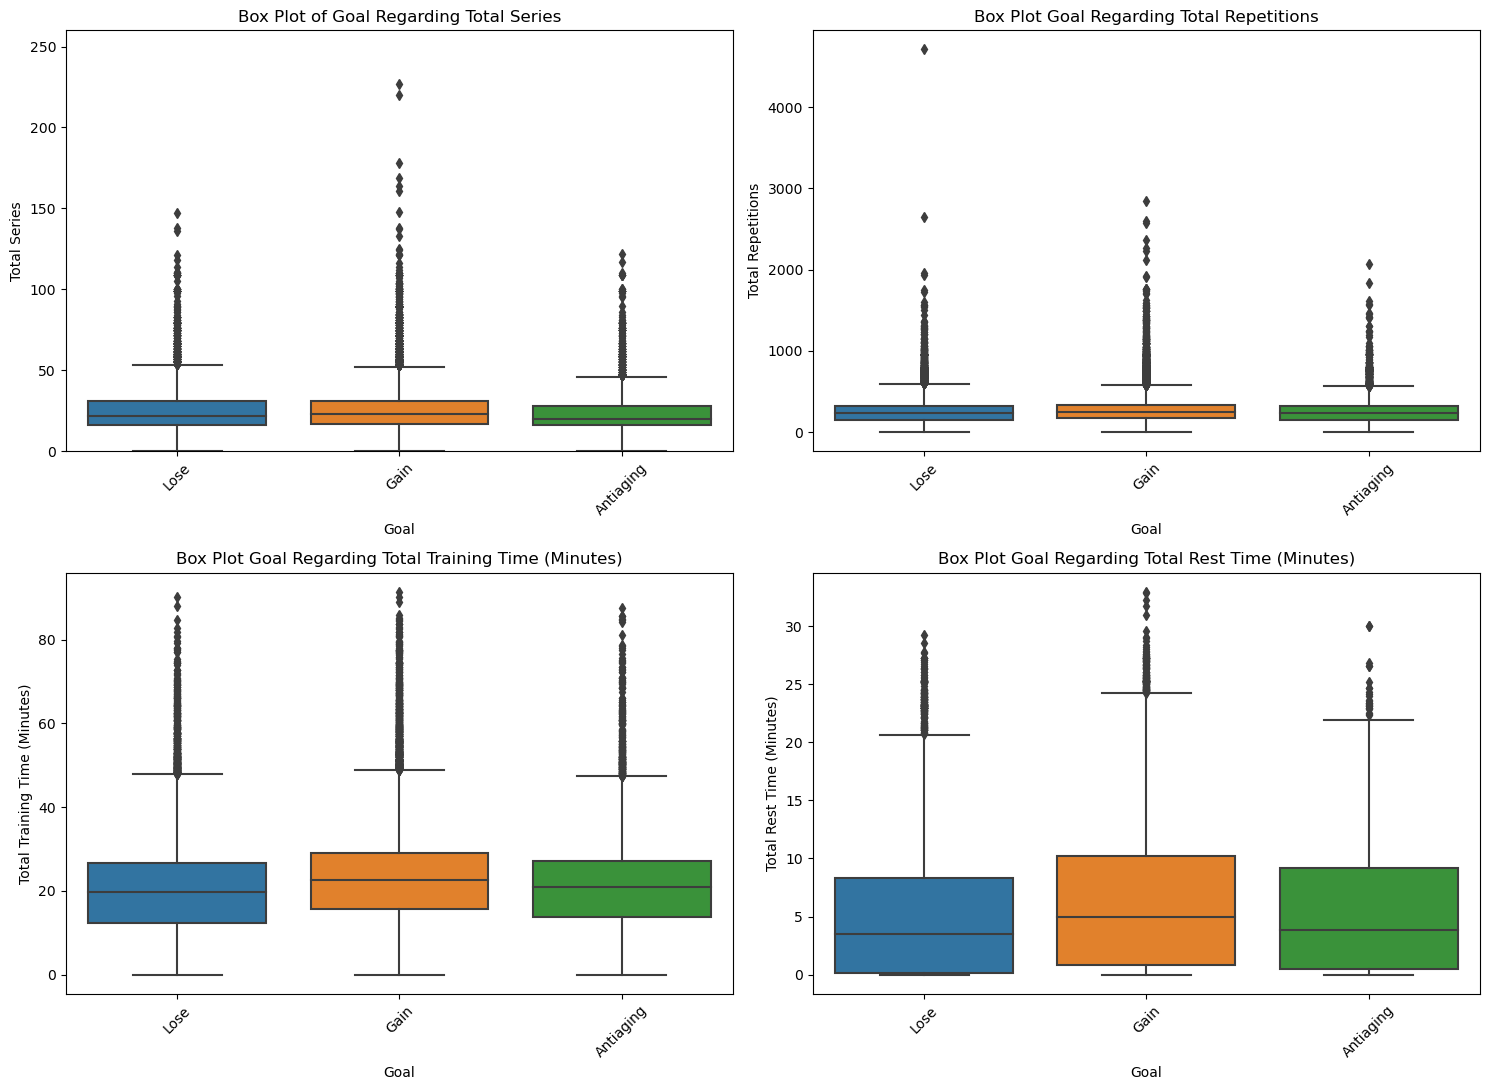

Total Number Of Users With Each Specific Goal:
           Count Percentage
Gain       24354     52.92%
Lose       13870     30.14%
Antiaging   7796     16.94%


In [55]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# Plot 1: Goal vs Series Comparison
sns.boxplot(ax=axes[0, 0], x='users_goal', y='total_count_of_series_reps', data=df_filtered_merged)
axes[0, 0].set_title('Box Plot of Goal Regarding Total Series')
axes[0, 0].set_ylim(0, 260)
axes[0, 0].set_xlabel('Goal')
axes[0, 0].set_ylabel('Total Series')
axes[0, 0].set_xticklabels(['Lose', 'Gain', 'Antiaging'], rotation=45)

# Plot 2: Goal vs Repetitions Comparison
sns.boxplot(ax=axes[0, 1], x='users_goal', y='sum_of_reps', data=df_filtered_merged)
axes[0, 1].set_title('Box Plot Goal Regarding Total Repetitions')
axes[0, 1].set_xlabel('Goal')
axes[0, 1].set_ylabel('Total Repetitions')
axes[0, 1].set_xticklabels(['Lose', 'Gain', 'Antiaging'], rotation=45)

# Plot 3: Goal vs Training Time Comparison
sns.boxplot(ax=axes[1, 0], x='users_goal', y=df_filtered_merged['sum_of_time'] / 60, data=df_filtered_merged)
axes[1, 0].set_title('Box Plot Goal Regarding Total Training Time (Minutes)')
axes[1, 0].set_xlabel('Goal')
axes[1, 0].set_ylabel('Total Training Time (Minutes)')
axes[1, 0].set_xticklabels(['Lose', 'Gain', 'Antiaging'], rotation=45)

# Plot 4: Goal vs Rest Time Comparison
sns.boxplot(ax=axes[1, 1], x='users_goal', y=df_filtered_merged['Rest_sum_of_time_per_exercise'] / 60, data=df_filtered_merged)
axes[1, 1].set_title('Box Plot Goal Regarding Total Rest Time (Minutes)')
axes[1, 1].set_xlabel('Goal')
axes[1, 1].set_ylabel('Total Rest Time (Minutes)')
axes[1, 1].set_xticklabels(['Lose', 'Gain', 'Antiaging'], rotation=45)

plt.tight_layout()
plt.show()

goal_counts = df_filtered_merged['users_goal'].value_counts()
total_users = goal_counts.sum()
goal_percentages = (goal_counts / total_users) * 100
goal_names = {0: 'Lose', 1: 'Gain', 2: 'Antiaging'}
goal_counts_named = goal_counts.rename(index=goal_names)
goal_percentages_named = goal_percentages.rename(index=goal_names)
goal_summary = pd.DataFrame({'Count': goal_counts_named, 'Percentage': goal_percentages_named})
goal_summary['Percentage'] = goal_summary['Percentage'].map(lambda x: f'{x:.2f}%')

print("Total Number Of Users With Each Specific Goal:")
print(goal_summary)


##### **Conclusion on the Results of the Plots: Comparison with the Goal**

The series of box plots and pie charts provide a comprehensive comparison of different metrics (total series, total repetitions, total training time, and total rest time) across various goals: Lose, Gain, and Antiaging.

**Box Plots Analysis**

- **Total Series**: The box plots for total series show a similar distribution for all goals, with some outliers present. The median values are relatively close, but the distribution range is wider for the 'Gain' goal.

- **Total Repetitions**: The distribution of total repetitions is also similar across all goals. However, the 'Gain' goal shows a few extreme outliers, indicating higher values for some instances.

- **Total Training Time**: Total training time is fairly consistent across all goals. The median values are close, but the 'Gain' goal shows slightly higher upper quartiles, suggesting longer training sessions for some individuals.

- **Total Rest Time**: The total rest time box plots reveal a consistent distribution across goals, with some outliers. The median values indicate that individuals with the 'Gain' goal tend to have slightly longer rest periods.

**Proportion Analysis**

The summary printed at the end represents the proportion of each goal category within the dataset for the different metrics:

- **Goal Proportions**:
   - **Gain (1)**: This category consistently makes up the majority in all metrics, with around 53% of the data.
   - **Lose (0)**: The second largest group, representing approximately 30% of the data, suggesting a significant number of individuals aim to lose.
   - **Antiaging (2)**: The smallest group, making up about 17% of the data, indicates a smaller subset of individuals focused on antiaging.



Overall, the visualizations highlight that the 'Gain' goal dominates the dataset, making up more than half of the observations across all metrics. The box plots indicate that while the distribution of total series, total repetitions, total training time, and total rest time are relatively similar across goals, there are slight variations in the distribution and presence of outliers. These insights help in understanding the data's structure and the focus areas of different individuals based on their goals, guiding further analysis and targeted interventions.

### **Comparisons with Gender**

The primary purpose of comparing gender with series, repetitions, training time, and rest time is to understand how different training routines impact male and female athletes differently. This analysis helps in identifying patterns and trends that can provide valuable insights for optimizing training programs based on gender-specific needs.

- Gender vs Series: Determine how the number of series varies between male and female athletes.
- Gender vs Repetitions: Analyze the relationship between gender and the number of repetitions per series.
- Gender vs Training Time: Assess how total training time per session differs between genders.
- Gender vs Rest Time: Investigate variations in rest periods between exercises for male and female athletes.

In conclusion, understanding these comparisons could help tailor workout routines to gender-specific needs, optimizing training effectiveness and efficiency.

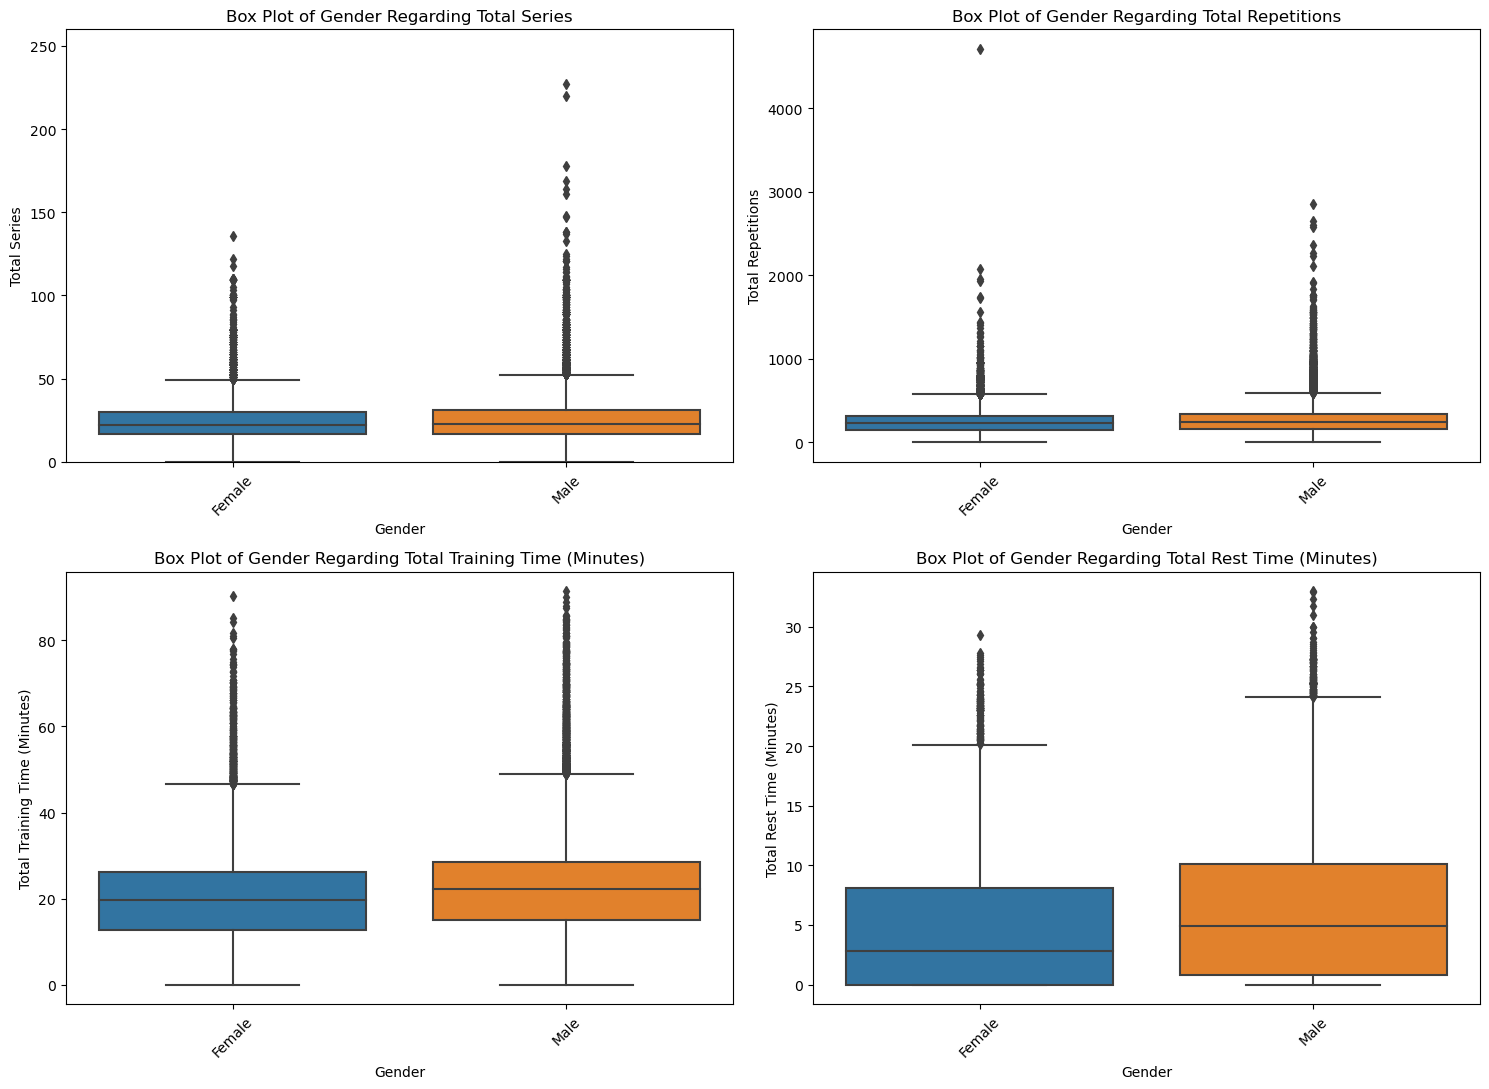

Total Number Of Users Of Each Gender:
        Count Percentage
Male    33195     72.13%
Female  12825     27.87%


In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# Plot 1: Gender vs Series Comparison
sns.boxplot(ax=axes[0, 0], x='users_gender', y='total_count_of_series_reps', data=df_filtered_merged)
axes[0, 0].set_title('Box Plot of Gender Regarding Total Series')
axes[0, 0].set_ylim(0, 260)
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Total Series')
axes[0, 0].set_xticklabels(['Female', 'Male'], rotation=45)

# Plot 2: Gender vs Repetitions Comparison
sns.boxplot(ax=axes[0, 1], x='users_gender', y='sum_of_reps', data=df_filtered_merged)
axes[0, 1].set_title('Box Plot of Gender Regarding Total Repetitions')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Total Repetitions')
axes[0, 1].set_xticklabels(['Female', 'Male'], rotation=45)

# Plot 3: Gender vs Training Time Comparison
sns.boxplot(ax=axes[1, 0], x='users_gender', y=df_filtered_merged['sum_of_time'] / 60, data=df_filtered_merged)
axes[1, 0].set_title('Box Plot of Gender Regarding Total Training Time (Minutes)')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Total Training Time (Minutes)')
axes[1, 0].set_xticklabels(['Female', 'Male'], rotation=45)

# Plot 4: Gender vs Rest Time Comparison
sns.boxplot(ax=axes[1, 1], x='users_gender', y=df_filtered_merged['Rest_sum_of_time_per_exercise'] / 60, data=df_filtered_merged)
axes[1, 1].set_title('Box Plot of Gender Regarding Total Rest Time (Minutes)')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Total Rest Time (Minutes)')
axes[1, 1].set_xticklabels(['Female', 'Male'], rotation=45)

plt.tight_layout()
plt.show()


gender_counts = df_filtered_merged['users_gender'].value_counts()
total_users = gender_counts.sum()
gender_percentages = (gender_counts / total_users) * 100
gender_names = {0: 'Female', 1: 'Male'}
gender_counts_named = gender_counts.rename(index=gender_names)
gender_percentages_named = gender_percentages.rename(index=gender_names)
gender_summary = pd.DataFrame({'Count': gender_counts_named, 'Percentage': gender_percentages_named})
gender_summary['Percentage'] = gender_summary['Percentage'].map(lambda x: f'{x:.2f}%')

print("Total Number Of Users Of Each Gender:")
print(gender_summary)

#### **Conclusion on the Results of the Plots: Comparison with Gender**

The series of box plots and pie charts provide a detailed comparison of various metrics (total series, total repetitions, total training time, and total rest time) across gender categories: Female (0) and Male (1).

**Box Plots Analysis**

- **Total Series**: The box plots for total series show that males tend to have a slightly higher range of total series compared to females, with a few extreme outliers in both genders. The median values are similar, indicating that the central tendency for total series does not differ significantly between genders.

- **Total Repetitions**: For total repetitions, both genders have similar distributions with a few extreme outliers. Males exhibit a slightly higher range, but the median values for both genders are close, indicating comparable repetition counts on average.

- **Total Training Time**: The total training time box plots reveal that the distribution is quite similar for both genders. The median values and interquartile ranges are close, with males showing a marginally higher upper range of training time.

- **Total Rest Time**: The total rest time box plots show that males tend to have a higher range and median rest time compared to females. There are outliers present in both genders, but the central tendency indicates that males generally rest more during training sessions.

**Proportion Analysis**

The summary printed at the end represents the proportion of each gender category within the dataset for the different metrics:

- **Gender Proportions**:
   - **Female (0)**: The second largest group, representing approximately 28% of the data, suggesting a lower but significant representation of females.
   - **Male (1)**: This category consistently makes up the majority in all metrics, with around 72% of the data, indicating a higher representation of males in the dataset.

Overall, the visualizations highlight that males dominate the dataset, making up the majority of observations across all metrics. The box plots indicate that while the distribution of total series, total repetitions, total training time, and total rest time are relatively similar between genders, males tend to exhibit slightly higher ranges and median values in most metrics. These insights help in understanding the data's structure and the differences in training behaviors based on gender, guiding further analysis and targeted interventions.

### **Comparisons with Body Fat**

The primary purpose of comparing body fat with series, repetitions, training time, and rest time is to understand how different body fat percentages impact various aspects of a workout routine. This analysis helps in identifying patterns and trends that can provide valuable insights for optimizing training programs based on body fat levels.

- Body Fat vs Series: Determine how the number of series varies with different body fat percentages.
- Body Fat vs Repetitions: Analyze the relationship between body fat levels and the number of repetitions per series.
- Body Fat vs Training Time: Assess how total training time per session is influenced by different body fat percentages.
- Body Fat vs Rest Time: Investigate variations in rest periods between exercises for different body fat levels.

In conclusion, understanding these comparisons could help tailor workout routines to specific body fat levels, optimizing training effectiveness and efficiency.

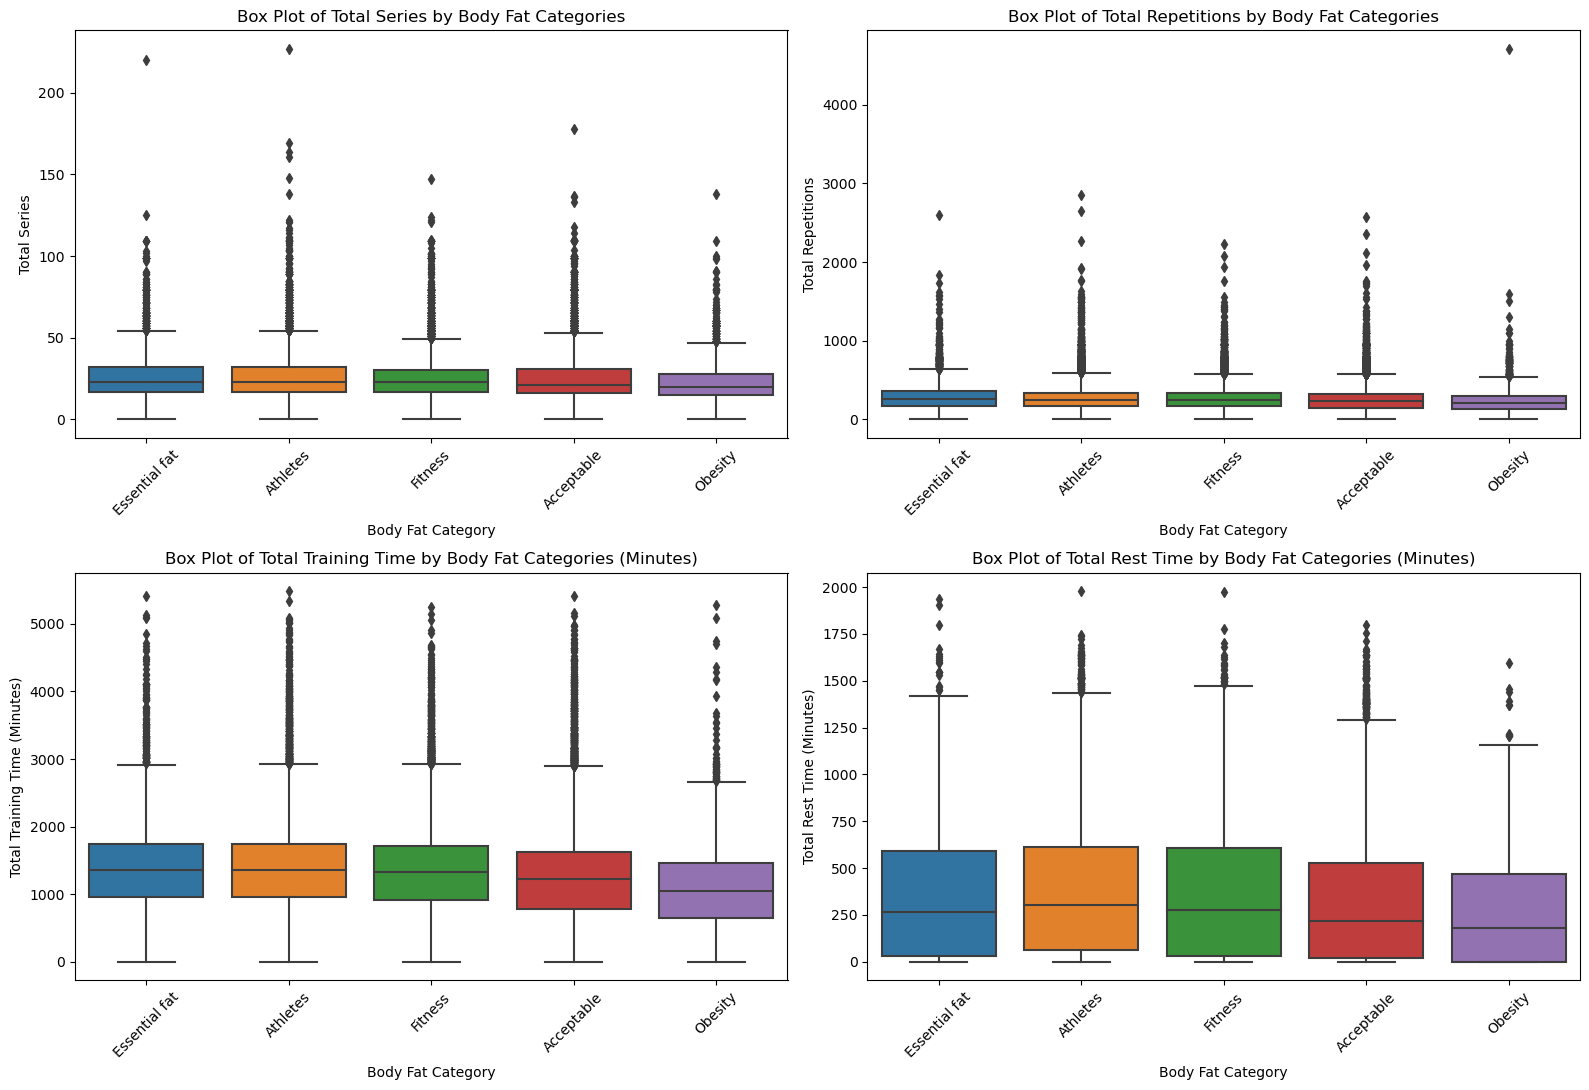

Total Number Of Users In Each Body Fat Category:
               Count Percentage
Acceptable     14013     30.66%
Fitness        12813     28.04%
Athletes       11460     25.08%
Obesity         3994      8.74%
Essential fat   3421      7.49%


In [62]:
# Define body fat categories with correct boundaries to avoid overlaps
body_fat_bins = [10, 13, 20, 24, 31, float('inf')]
body_fat_labels = ['Essential fat', 'Athletes', 'Fitness', 'Acceptable', 'Obesity']

# Categorize the body fat percentages
df_filtered_merged['body_fat_category'] = pd.cut(
    df_filtered_merged['users_body_fat'], 
    bins=body_fat_bins, 
    labels=body_fat_labels, 
    right=False
)

fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# Plot 1: Body Fat Categories vs Series Comparison
sns.boxplot(ax=axes[0, 0], x='body_fat_category', y='total_count_of_series_reps', data=df_filtered_merged)
axes[0, 0].set_title('Box Plot of Total Series by Body Fat Categories')
axes[0, 0].set_xlabel('Body Fat Category')
axes[0, 0].set_ylabel('Total Series')
axes[0, 0].set_xticklabels(body_fat_labels, rotation=45)

# Plot 2: Body Fat Categories vs Repetitions Comparison
sns.boxplot(ax=axes[0, 1], x='body_fat_category', y='sum_of_reps', data=df_filtered_merged)
axes[0, 1].set_title('Box Plot of Total Repetitions by Body Fat Categories')
axes[0, 1].set_xlabel('Body Fat Category')
axes[0, 1].set_ylabel('Total Repetitions')
axes[0, 1].set_xticklabels(body_fat_labels, rotation=45)

# Plot 3: Body Fat Categories vs Training Time Comparison
sns.boxplot(ax=axes[1, 0], x='body_fat_category', y='sum_of_time', data=df_filtered_merged)
axes[1, 0].set_title('Box Plot of Total Training Time by Body Fat Categories (Minutes)')
axes[1, 0].set_xlabel('Body Fat Category')
axes[1, 0].set_ylabel('Total Training Time (Minutes)')
axes[1, 0].set_xticklabels(body_fat_labels, rotation=45)

# Plot 4: Body Fat Categories vs Rest Time Comparison
sns.boxplot(ax=axes[1, 1], x='body_fat_category', y='Rest_sum_of_time_per_exercise', data=df_filtered_merged)
axes[1, 1].set_title('Box Plot of Total Rest Time by Body Fat Categories (Minutes)')
axes[1, 1].set_xlabel('Body Fat Category')
axes[1, 1].set_ylabel('Total Rest Time (Minutes)')
axes[1, 1].set_xticklabels(body_fat_labels, rotation=45)

plt.tight_layout()
plt.show()

body_fat_counts = df_filtered_merged['body_fat_category'].value_counts()
total_users = body_fat_counts.sum()
body_fat_percentages = (body_fat_counts / total_users) * 100
body_fat_summary = pd.DataFrame({'Count': body_fat_counts, 'Percentage': body_fat_percentages})
body_fat_summary['Percentage'] = body_fat_summary['Percentage'].map(lambda x: f'{x:.2f}%')

print("Total Number Of Users In Each Body Fat Category:")
print(body_fat_summary)


#### **Conclusion on the Results of the Plots: Comparison with Body Fat Categories**

The series of box plots and summary table provide a detailed comparison of various metrics (total series, total repetitions, total training time, and total rest time) across different body fat categories: Essential fat, Athletes, Fitness, Acceptable, and Obesity.

**Box Plots Analysis**

- **Total Series**: The box plot shows that users in the "Essential fat" and "Athletes" categories tend to have a slightly higher range of total series, with more outliers compared to other categories. However, the median values across all categories are quite similar, indicating no significant central tendency differences.

- **Total Repetitions**: The distribution of total repetitions is fairly consistent across all body fat categories. The "Essential fat" and "Athletes" categories show a slightly higher range and median values, but overall, the differences are minimal.

- **Total Training Time**: The total training time box plots reveal that users in the "Essential fat" category tend to have a higher median training time. The "Obesity" category shows the lowest median training time, indicating less overall training duration compared to other categories.

- **Total Rest Time**: The rest time box plots indicate that all categories have a relatively similar distribution, with the "Essential fat" and "Athletes" categories showing slightly higher median rest times. There are more outliers in the "Obesity" category, suggesting variability in rest times among users with higher body fat percentages.

**Proportion Analysis**

The summary table shows the proportion of users within each body fat category:

- **Body Fat Proportions**:
   - **Acceptable**: The largest group, representing approximately 31% of the data, indicating a significant portion of users fall within this range.
   - **Fitness**: Represents about 28% of the data, showing a high prevalence of users with fitness-level body fat percentages.
   - **Athletes**: Comprises about 25% of the users, indicating a considerable number of users in this active category.
   - **Obesity**: Accounts for approximately 9% of the data, suggesting a smaller but notable group with higher body fat percentages.
   - **Essential fat**: The smallest group, making up around 7% of the data, highlighting fewer users with very low body fat percentages.

Overall, the visualizations and summary highlight that while the distribution of total series, repetitions, training time, and rest time are relatively similar across body fat categories, those in the "Essential fat" and "Athletes" categories tend to exhibit slightly higher ranges and median values in most metrics. These insights provide a better understanding of the dataset's structure and the variations in training behaviors based on body fat categories, guiding further analysis and targeted fitness interventions.

### **Comparisons with Age**

The primary purpose of comparing age with series, repetitions, training time, and rest time is to understand how different age groups impact various aspects of a workout routine. This analysis helps in identifying patterns and trends that can provide valuable insights for optimizing training programs based on age-specific needs.

- Age vs Series: Determine how the number of series varies with different age groups.
- Age vs Repetitions: Analyze the relationship between age and the number of repetitions per series.
- Age vs Training Time: Assess how total training time per session is influenced by different age groups.
- Age vs Rest Time: Investigate variations in rest periods between exercises for different age groups.

In conclusion, understanding these comparisons could help tailor workout routines to specific age groups, optimizing training effectiveness and efficiency.

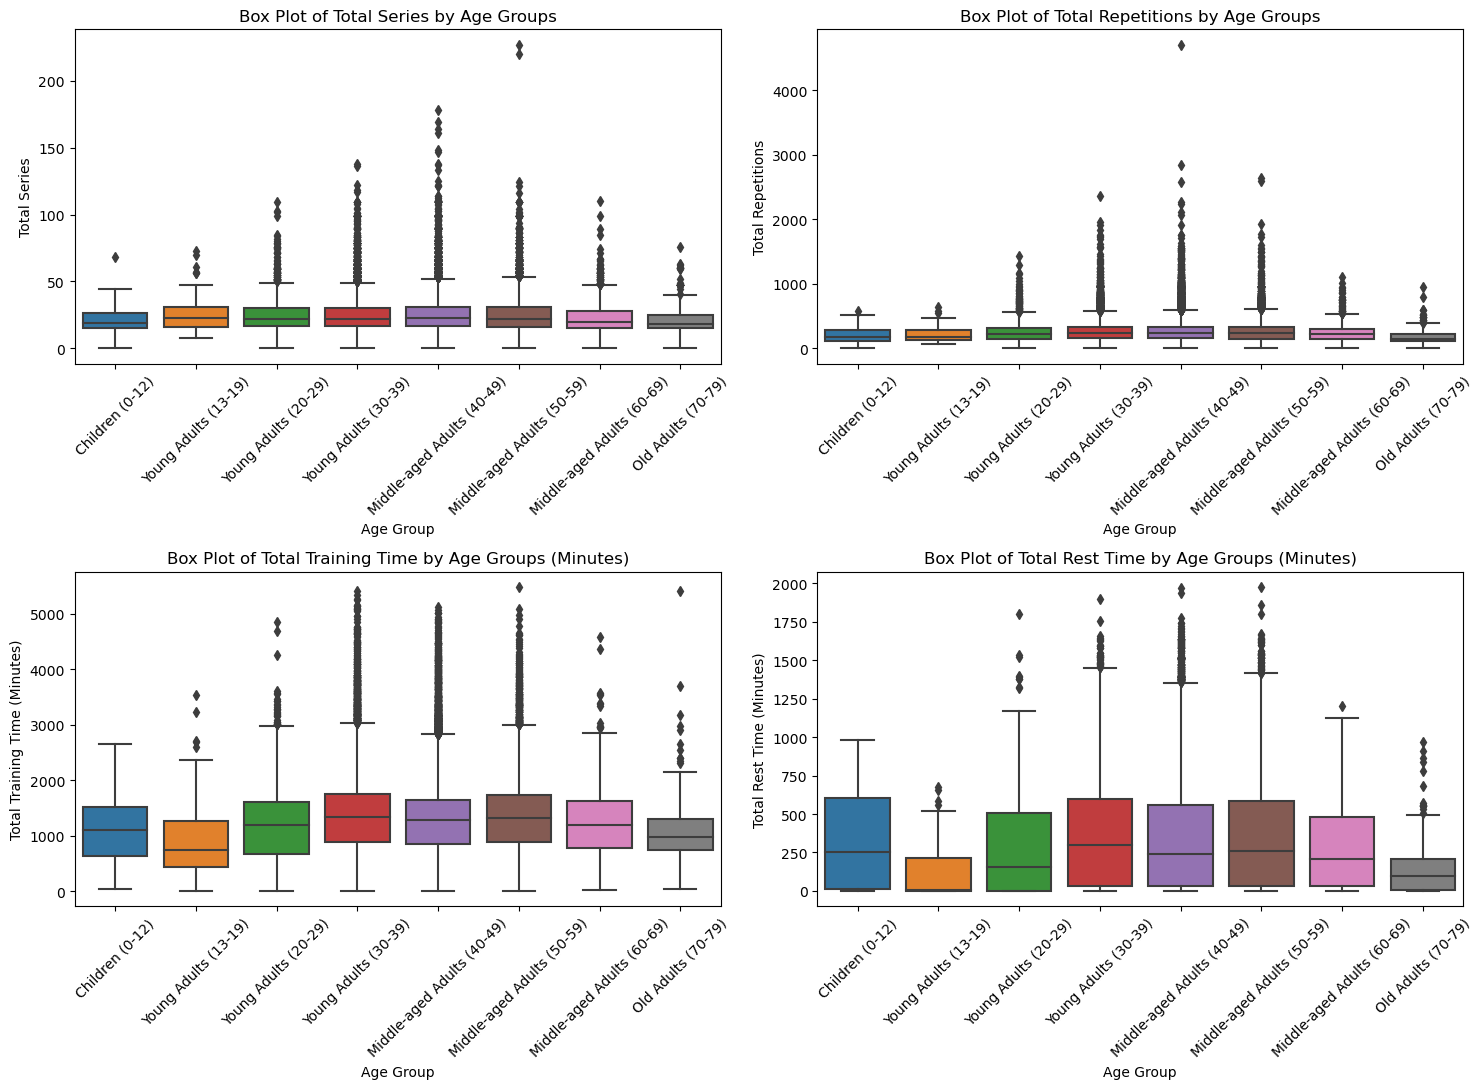

Total Number Of Users In Each Age Group:
                            Count Percentage
Middle-aged Adults (40-49)  22107     48.04%
Young Adults (30-39)        11550     25.10%
Middle-aged Adults (50-59)   9207     20.01%
Young Adults (20-29)         1673      3.64%
Middle-aged Adults (60-69)    960      2.09%
Old Adults (70-79)            346      0.75%
Young Adults (13-19)           99      0.22%
Children (0-12)                78      0.17%


In [71]:
# Define age categories with correct boundaries to avoid overlaps
age_bins = [0, 13, 20, 30, 40, 50, 60, 70, 80]
age_labels = [
    'Children (0-12)', 'Young Adults (13-19)', 'Young Adults (20-29)',
    'Young Adults (30-39)', 'Middle-aged Adults (40-49)', 'Middle-aged Adults (50-59)',
    'Middle-aged Adults (60-69)', 'Old Adults (70-79)'
]

df_filtered_merged['users_date_of_birth'] = pd.to_datetime(df_filtered_merged['users_date_of_birth'])
df_filtered_merged['age'] = (pd.to_datetime('today') - df_filtered_merged['users_date_of_birth']).dt.days // 365
# Categorize the ages
df_filtered_merged['age_group'] = pd.cut(df_filtered_merged['age'], bins=age_bins, labels=age_labels, right=False)

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# Plot 1: Age Group vs Series Comparison
sns.boxplot(ax=axes[0, 0], x='age_group', y='total_count_of_series_reps', data=df_filtered_merged)
axes[0, 0].set_title('Box Plot of Total Series by Age Groups')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Total Series')
axes[0, 0].set_xticklabels(age_labels, rotation=45)

# Plot 2: Age Group vs Repetitions Comparison
sns.boxplot(ax=axes[0, 1], x='age_group', y='sum_of_reps', data=df_filtered_merged)
axes[0, 1].set_title('Box Plot of Total Repetitions by Age Groups')
axes[0, 1].set_xlabel('Age Group')
axes[0, 1].set_ylabel('Total Repetitions')
axes[0, 1].set_xticklabels(age_labels, rotation=45)

# Plot 3: Age Group vs Training Time Comparison
sns.boxplot(ax=axes[1, 0], x='age_group', y='sum_of_time', data=df_filtered_merged)
axes[1, 0].set_title('Box Plot of Total Training Time by Age Groups (Minutes)')
axes[1, 0].set_xlabel('Age Group')
axes[1, 0].set_ylabel('Total Training Time (Minutes)')
axes[1, 0].set_xticklabels(age_labels, rotation=45)

# Plot 4: Age Group vs Rest Time Comparison
sns.boxplot(ax=axes[1, 1], x='age_group', y='Rest_sum_of_time_per_exercise', data=df_filtered_merged)
axes[1, 1].set_title('Box Plot of Total Rest Time by Age Groups (Minutes)')
axes[1, 1].set_xlabel('Age Group')
axes[1, 1].set_ylabel('Total Rest Time (Minutes)')
axes[1, 1].set_xticklabels(age_labels, rotation=45)

plt.tight_layout()
plt.show()

age_counts = df_filtered_merged['age_group'].value_counts()
total_users = age_counts.sum()
age_percentages = (age_counts / total_users) * 100
age_summary = pd.DataFrame({'Count': age_counts, 'Percentage': age_percentages})
age_summary['Percentage'] = age_summary['Percentage'].map(lambda x: f'{x:.2f}%')

print("Total Number Of Users In Each Age Group:")
print(age_summary)


#### **Conclusion on the Results of the Plots: Comparison with Age Groups**

The series of box plots and the summary table provide a detailed comparison of various metrics (total series, total repetitions, total training time, and total rest time) across different age groups: Children (0-12), Young Adults (13-19, 20-29, 30-39), Middle-aged Adults (40-49, 50-59, 60-69), and Old Adults (70-79).

**Box Plots Analysis**

- **Total Series**: The box plots for total series show that all age groups have a wide range of total series counts, with a few extreme outliers. The "Middle-aged Adults (40-49)" category has a slightly higher range and median total series compared to other age groups, indicating more series counts on average for this group.

- **Total Repetitions**: For total repetitions, the distribution is relatively consistent across all age groups, with the "Middle-aged Adults (40-49)" and "Middle-aged Adults (50-59)" categories showing slightly higher ranges and median values. This suggests that these middle-aged groups tend to perform more repetitions on average.

- **Total Training Time**: The total training time box plots reveal that the distribution is fairly similar for all age groups, with the "Middle-aged Adults (40-49)" category showing a marginally higher upper range and median training time. This indicates that individuals in this age group tend to spend more time training.

- **Total Rest Time**: The total rest time box plots indicate that the rest time distribution is similar across all age groups, with some outliers present. The "Middle-aged Adults (40-49)" and "Middle-aged Adults (50-59)" categories tend to have higher ranges and median rest times, suggesting that these groups take more rest during training sessions.

**Proportion Analysis**

The summary printed at the end represents the proportion of each age group within the dataset for the different metrics:

- **Age Group Proportions**:
   - **Middle-aged Adults (40-49)**: The largest group, representing approximately 48% of the data, indicating a significant representation of individuals in this age range.
   - **Young Adults (30-39)**: The second largest group, making up about 25% of the data, suggesting a high prevalence of young adults in this age category.
   - **Middle-aged Adults (50-59)**: This group accounts for around 20% of the data, highlighting a substantial portion of individuals in this age range.
   - **Young Adults (20-29)**: Comprising about 4% of the data, indicating a smaller representation of young adults in this category.
   - **Middle-aged Adults (60-69)**: Representing approximately 2% of the data, showing a lower but notable presence.
   - **Old Adults (70-79)**: Making up about 1% of the data, indicating a small representation of older adults.
   - **Young Adults (13-19)**: This group accounts for about 0.2% of the data, highlighting a very small portion of teenagers.
   - **Children (0-12)**: The smallest group, representing about 0.2% of the data, indicating very few children in the dataset.

Overall, the visualizations highlight that middle-aged adults (particularly those aged 40-49) dominate the dataset, making up the majority of observations across all metrics. The box plots indicate that while the distribution of total series, total repetitions, total training time, and total rest time are relatively similar across age groups, middle-aged adults tend to exhibit slightly higher ranges and median values in most metrics. These insights help in understanding the data's structure and the differences in training behaviors based on age groups, guiding further analysis and targeted fitness interventions.

----
----
----
----

## Comparing Body Fat, Goal and Age with respect to the Gender

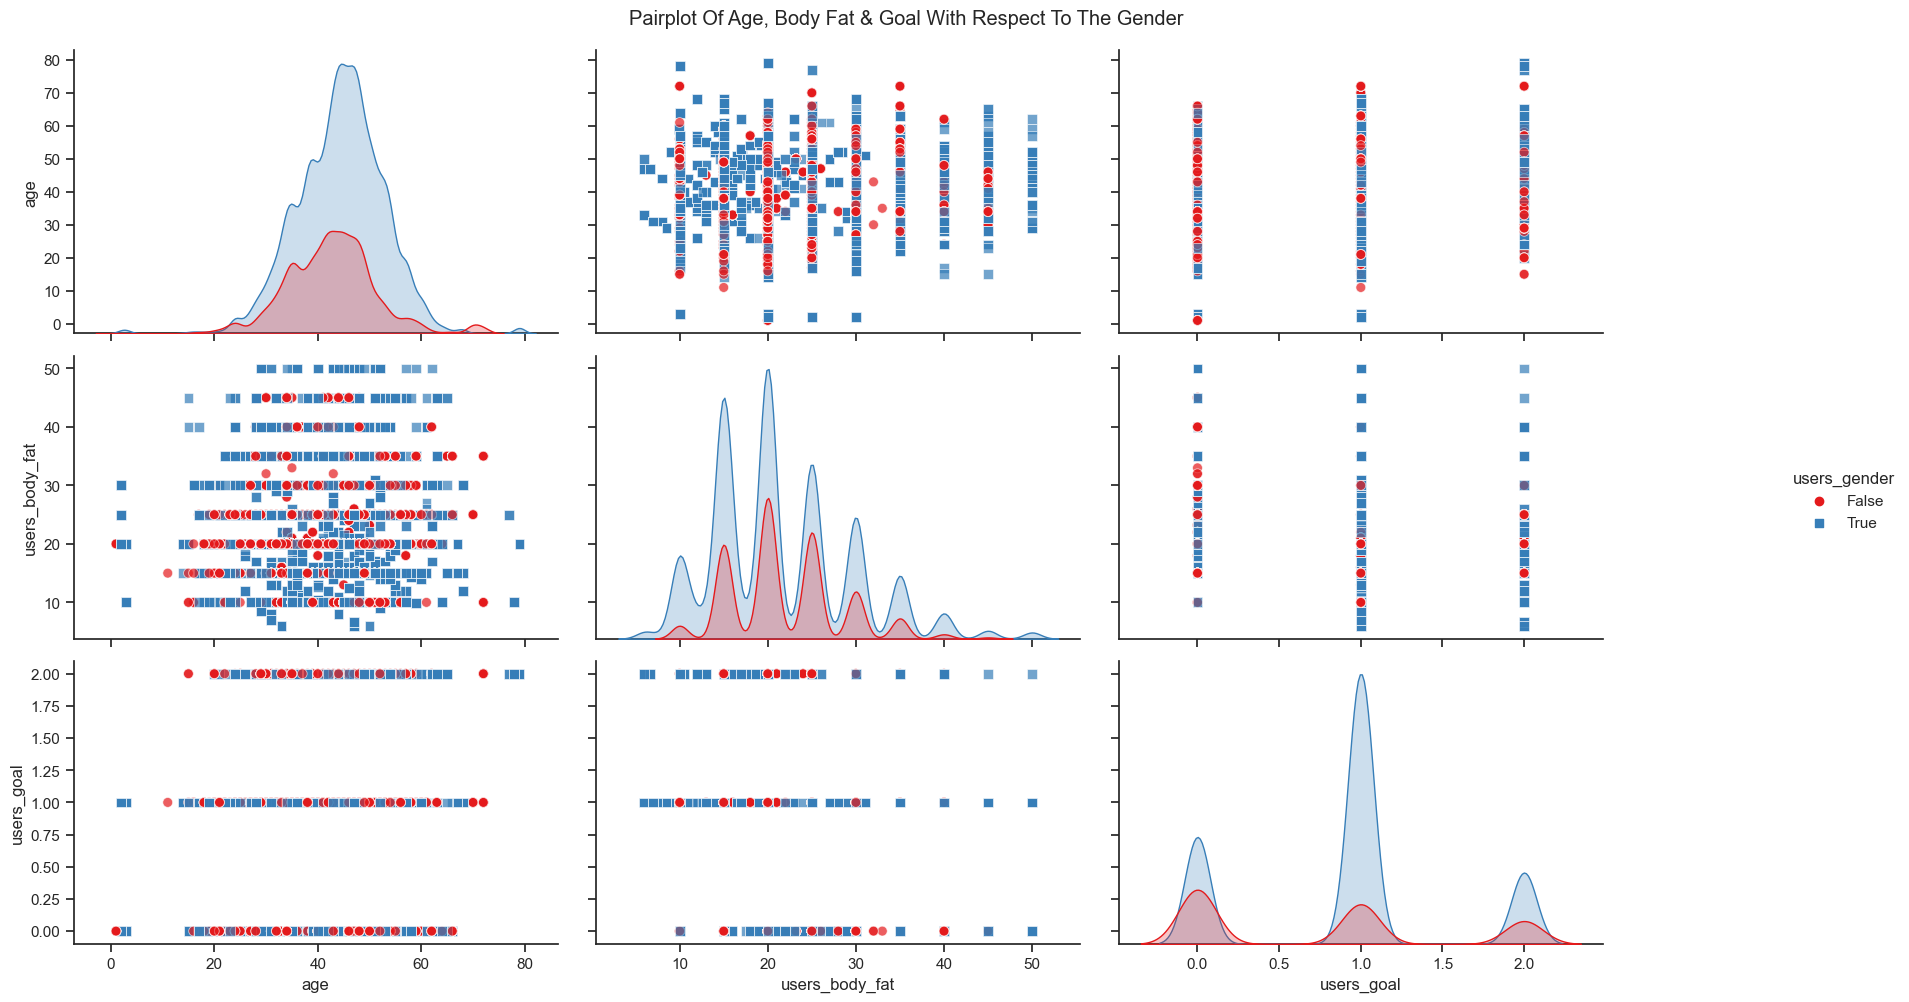

In [78]:
# PAIR PLOT COMPARING BODY FAT, AGE AND GOAL WITH RESPECT TO THE GENDER
df_selected = df_filtered_merged[['age', 'users_body_fat', 'users_gender', 'users_goal']]
sns.set(style="ticks")
pairplot = sns.pairplot(df_selected, hue='users_gender', diag_kind='kde', markers=['o', 's'], palette='Set1',
                        plot_kws={'alpha': 0.7, 's': 50}, diag_kws={'shade': True})
pairplot.fig.suptitle('Pairplot Of Age, Body Fat & Goal With Respect To The Gender', y=1.02)
pairplot.fig.set_size_inches(20, 10)
plt.show()

# TODO change the 0 and 1 by male and female in the graphs

The pairplot presented here visualizes the relationships between three variables: age, body fat percentage, and goal, with respect to gender. The variables are plotted against each other in a matrix format, with different genders distinguished by color and shape. Red circles for gender 0 (Female) and blue squares for gender 1 (Male). Here's a detailed interpretation of the graph:

### Diagonal Plots:
- **Age Distribution:** The age distribution shows that male individuals (blue) are more prevalent across a wider age range, from approximately 20 to 80 years. Female individuals (red) have a peak around the younger age group, primarily between 30 and 50 years.
  - **Example:** There is a noticeable concentration of male individuals (blue) around ages 30-40 and 50-60, but the highest concentration of males if located around ages 40-50.

- **Body Fat Distribution:** The body fat distribution for males (blue) shows multiple peaks, indicating a varied distribution. In contrast, females (red) have a more uniform distribution with a lower overall range.
  - **Example:** Males show peaks in body fat around 10%, 20%, and 30%, while females have a more concentrated distribution around 20-30%.

- **Goal Distribution:** The goal distribution for males (blue) shows three distinct peaks, suggesting different target groups or objectives. Females (red) have a less pronounced peak.
  - **Example:** Males (blue) have peaks at goals 0 (Lose), 1 (Gain), and 2 (Antiaging), but with a higher concentration of individuals at goal 1 (Gain), whereas females (red) have a higher concentration around goal 0 (Lose).

### Off-Diagonal Plots:
- **Age vs. Body Fat:** This scatter plot indicates that body fat percentage does not have a clear correlation with age for either gender. Both genders show a wide spread of body fat percentages across all ages, but males (blue) appear more scattered.
  - **Example:** Both males and females have body fat percentages ranging from 10% to 50% across ages 20 to 70. Males around age 50 have body fat percentages from 10% to 40%, while females around the same age range from 15% to 35%.

- **Age vs. Goal:** This plot illustrates that goals are not strongly correlated with age for either gender. However, there are more data points for males (blue) at each goal level compared to females (red).
  - **Example:** A higher number of users with goal 1 (Gain) are in the age range of 35-50 years old, with both males and females showing significant presence.

- **Body Fat vs. Goal:** Similar to the age vs. goal plot, there isn't a strong correlation between body fat and goal. Both genders have a wide spread of body fat percentages across different goal levels, but again, males (blue) show a more varied distribution.
  - **Example:** There is a higher amount of users with goal 1 (Gain) in different levels of body fat, particularly around 20-30%. Males in this body fat range are pursuing all three goals, while females are more concentrated around goal 0 (Lose).

### Summary:
- **Gender Differences:**
  - **Age:** Male individuals (blue) include individuals of a wider age range (20-80 years) compared to female individuals (red), who are more concentrated around the younger age range (20-50 years).
  - **Body Fat:** Male individuals (blue) show a more varied body fat distribution with peaks around 10%, 15%, 20%, 30% and 35%. Female individuals (red) have a more concentrated distribution around 20-30%.
  - **Goal:** Male individuals (blue) have distinct peaks indicating different goal levels (Lose, Gain, Antiaging), with a higher peak at goal 1 (Gain), while female individuals (red) are more uniformly distributed with a focus on goal 0 (Lose).

### Insights:
- **Diversity in Males:** There is noticeable diversity within male individuals (blue) across all variables, suggesting a wide range of ages, body fat percentages, and goals.
  - **Example:** Males aged 40-50 have body fat percentages ranging from 10% to 40%, pursuing goals 0 (Lose), 1 (Gain), and 2 (Antiaging).

- **Homogeneity in Females:** Female individuals (red circles) tend to have less variation, particularly in age and body fat, indicating a more homogeneous group.
  - **Example:** Females aged 30-50 with body fat percentages of 20-30% predominantly pursue goal 0 (Lose).

The pairplot provides a comprehensive view of how age, body fat, and goal are distributed and interrelated across genders, highlighting the variations and similarities between male and female groups with concrete data examples.

1.  In general it was a good analysis, apart from the TODO notes, is neccessary to analysis the folliwing variables:

columns_description = ['body_parts_focused',
                    'exercises_description_en',
                    'exercises_execution_time',
                    'exercises_joints',
                    'exercises_met_multiplier',
                    'exercises_muscles',
                    'exercises_t1_max',
                    'exercises_t1_min',
                    'exercises_test_correction',
                    'session_executions_created_at',
                    'session_executions_difficulty_feedback',
                    'session_executions_discarded',
                    'session_executions_enjoyment_feedback',
                    'session_executions_imported',
                    'session_executions_reps_executed',
                    'session_executions_user_program_id',
                    'sessions_calories',
                    'sessions_description_en',
                    'sessions_name_en',
                    'sessions_order',
                    'sessions_time_duration',
                    'user_programs_active',
                    'user_programs_completed',
                    'user_programs_program_id',
                    'user_programs_enjoyment',
                    'session_executions_updated_at', 
                    'user_programs_user_id',
                    'users_created_at',
                    'users_updated_at',
                    'users_gender',
                    'users_activity_level',
                    'users_body_type',
                    'users_newsletter_subscription',
                    'users_sign_in_count',
                    'users_notifications_setting',
                    'users_training_days_setting',
                    'users_country',
                    'users_points',
                    'users_scientific_data_usage',
                    'users_best_weekly_streak', 
                    'users_imported',
                    'session_executions_summary_updated_at'
                    ]

To make a summary of the analsys I propose.

To creata a subplot with two or three graphs from the variable itself and describet it

Next, in a single graph with subplots, analyze each variable in relation to every other variable from the dataset you previously analyzed here:

- **sum_of_reps**: Sum of all the rep values executed during the session.
- **sum_of_time**: Sum of the total time values for all the exercises during the session.
- **sum_of_reps_per_exercise**: Sum of the rep values executed during the session per exercise.
- **sum_of_time_per_exercise**: Sum of the time values during the session per exercise.
- **total_count_of_series_reps**: The count of the series for reps.
- **total_count_of_series_time**: The count of the sereis for time.

and aditionally:

'session_executions_summary_total_reps',
'session_executions_summary_total_kcal',
'session_executions_summary_effort',
'session_executions_summary_points',
'session_executions_summary_value_of_session',

2. Check why the body fat is wrong 